In [1]:
import pandas as pd
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import itertools
import json
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Code to load the old dataset without bounding boxes
# # use the following code to load dataset in your notebook

# with open("../data/processed/processed_sub_dataset.pkl", "rb") as f:
#     data_sub = pickle.load(f)
# print("Sub dataset keys:", data_sub.keys())

# with open("../data/processed/processed_full_dataset.pkl", "rb") as f:
#     data_full = pickle.load(f)
# print("Full dataset keys:", data_full.keys())

# # Assign variables for sub dataset
# X_train_sub = data_sub["X_train_sub"]
# y_train_sub = data_sub["y_train_sub"]
# X_val_sub = data_sub["X_val_sub"]
# y_val_sub = data_sub["y_val_sub"]
# classes_sub = data_sub["classes_sub"]

# # Assign variables for full dataset
# X_train = data_full["X_train"]
# y_train = data_full["y_train"]
# X_val = data_full["X_val"]
# y_val = data_full["y_val"]
# X_test = data_full["X_test"]
# y_test = data_full["y_test"]
# classes = data_full["classes"]

In [3]:
# Load processed datasets with _bbox suffix for all keys

with open("../data/processed/processed_sub_dataset.pkl", "rb") as f:
    data_sub = pickle.load(f)
print("Sub dataset keys:", data_sub.keys())

with open("../data/processed/processed_full_dataset.pkl", "rb") as f:
    data_full = pickle.load(f)
print("Full dataset keys:", data_full.keys())

# Assign variables for sub dataset (bbox keys)
X_train_sub = data_sub["X_train_sub_bbox"]
y_train_sub = data_sub["y_train_sub_bbox"]
X_val_sub = data_sub["X_val_sub_bbox"]
y_val_sub = data_sub["y_val_sub_bbox"]
classes_sub = data_sub["classes_sub_bbox"]

# Assign variables for full dataset (bbox keys)
X_train = data_full["X_train_bbox"]
y_train = data_full["y_train_bbox"]
X_val = data_full["X_val_bbox"]
y_val = data_full["y_val_bbox"]
X_test = data_full["X_test_bbox"]
y_test = data_full["y_test_bbox"]
classes = data_full["classes_bbox"]

Sub dataset keys: dict_keys(['X_train_sub_bbox', 'y_train_sub_bbox', 'X_val_sub_bbox', 'y_val_sub_bbox', 'classes_sub_bbox'])
Full dataset keys: dict_keys(['X_train_bbox', 'y_train_bbox', 'X_val_bbox', 'y_val_bbox', 'X_test_bbox', 'y_test_bbox', 'classes_bbox'])


# Data Dictionary & Function Definitions

### Stanford Dogs Dataset Dictionary Structure
### Data Dictionary
The dataset is organized into a dictionary with the following keys:

Training Data
* X_train_sub: Training images for a smaller subset of classes
* y_train_sub: Training labels for the smaller subset
* X_train: Training images for all 120 dog breed classes
* y_train: Training labels for all classes

Validation Data
* X_val_sub: Validation images for the smaller subset
* y_val_sub: Validation labels for the smaller subset
* X_val: Validation images for all classes
* y_val: Validation labels for all classes

Test Data
* X_test: Test images for all classes
* y_test: Test labels for all classes

Class Information
* classes: Array of all 120 dog breed class names
* classes_sub: Array of class names for the smaller subset


In [4]:
# Print some info to verify the data loaded correctly:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Number of classes:", len(classes))
print("First few classes:", classes[:5])

Training data shape: (12000, 64, 64, 3)
Training labels shape: (12000,)
Number of classes: 120
First few classes: ['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier']


In [5]:
# New data augmentation
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.03),
#     tf.keras.layers.RandomZoom(0.1),
#     tf.keras.layers.RandomContrast(0.1),
#     tf.keras.layers.RandomBrightness(0.1)
#     ])

# Old data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
], name="data_augmentation")

## Early Stopping Version

In [ ]:
# # Old build model version
# def build_model(n_classes,
#                 input_shape=(64, 64, 3),
#                 hidden_layer_sizes=None,
#                 activation='relu',
#                 optimizer='SGD',
#                 learning_rate=0.01,
#                 metric='accuracy',
#                 data_augmentation=None):
#     """Build a multi-class dense neural network with optional data augmentation."""
#     if hidden_layer_sizes is None:
#         hidden_layer_sizes = []

#     tf.keras.backend.clear_session()
#     np.random.seed(0)
#     tf.random.set_seed(0)

#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Input(shape=input_shape, name='Input'))

#     # Add augmentation if provided
#     if data_augmentation is not None:
#         model.add(data_augmentation)

#     model.add(tf.keras.layers.Flatten(name='Flatten'))

#     for i, units in enumerate(hidden_layer_sizes):
#         model.add(tf.keras.layers.Dense(units, activation=activation, name=f"Hidden_{i+1}"))

#     model.add(tf.keras.layers.Dense(
#         n_classes,
#         activation='softmax',
#         name='Output',
#         kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
#         bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)
#     ))

#     if optimizer == 'SGD':
#         opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
#     elif optimizer == 'Adam':
#         opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     else:
#         raise ValueError(f'Unsupported optimizer: {optimizer}')

#     model.compile(
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#         optimizer=opt,
#         metrics=[metric]
#     )

#     return model

### Latest Build Model

In [7]:
# -------------------  1. build_model  -------------------
def build_model(n_classes,
                input_shape=(64, 64, 3),
                hidden_layer_sizes=None,
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='accuracy',
                data_augmentation=None):
    """
    Build a fully-connected (dense) image classifier with optional data augmentation.
    """
    hidden_layer_sizes = hidden_layer_sizes or []

    # Keep results reproducible
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential(name="DenseClassifier")
    model.add(tf.keras.layers.Input(shape=input_shape, name="Input"))

    # Optional augmentation pipeline
    if data_augmentation is not None:
        model.add(data_augmentation)

    model.add(tf.keras.layers.Flatten(name='Flatten'))

    # Hidden layers
    for i, units in enumerate(hidden_layer_sizes):
        model.add(tf.keras.layers.Dense(units,
                                        activation=activation,
                                        name=f"Hidden_{i+1}"))

    # Output layer
    model.add(tf.keras.layers.Dense(
        n_classes,
        activation='softmax',
        name='Output',
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)
    ))

    # Optimizer
    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=opt,
        metrics=[metric]
    )
    return model


# ------------------- 2. train_and_evaluate  -------------------
def train_and_evaluate(X_train, y_train,
                       X_val,   y_val,
                       hidden_layer_sizes=None,
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=1e-3,
                       metric='accuracy',
                       num_epochs=10,
                       batch_size=64,
                       data_augmentation=None,
                       callbacks=None,
                       es_patience=3):
    """
    Build, train, and return a dense classifier (or a logistic-regression baseline).

    Early-Stopping:
        • If `callbacks` is supplied, we append to it.
        • If not, we create an EarlyStopping callback internally.
    """
    hidden_layer_sizes = hidden_layer_sizes or []

    # 1. Build
    n_classes = len(np.unique(y_train))
    model = build_model(n_classes=n_classes,
                        hidden_layer_sizes=hidden_layer_sizes,
                        activation=activation,
                        optimizer=optimizer,
                        learning_rate=learning_rate,
                        metric=metric,
                        data_augmentation=data_augmentation)

    # 2. Configure callbacks
    if callbacks is None:
        callbacks = [EarlyStopping(monitor='val_loss',
                                   patience=es_patience,
                                   restore_best_weights=True)]
    else:
        # Ensure we keep any user-provided callbacks while still restoring best weights
        seen_es = any(isinstance(cb, EarlyStopping) for cb in callbacks)
        if not seen_es:
            callbacks.append(EarlyStopping(monitor='val_loss',
                                           patience=es_patience,
                                           restore_best_weights=True))

    # 3. Train
    print(f"Training on {len(X_train)} images | validating on {len(X_val)} images")
    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # 4. Learning curves
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'],     label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5. Final val metrics
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Final validation accuracy: {val_acc:.4f}")

    return model

## Original without early stopping (Not used anymore)

In [ ]:
# Updated train_and_evaluate with early stopping
def train_and_evaluate(X_train, y_train,
                       X_val,   y_val,
                       hidden_layer_sizes=None,
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=1e-3,
                       metric='accuracy',
                       num_epochs=10,
                       batch_size=64,
                       data_augmentation=None):
    """
    Train a dense network (or logistic-regression baseline) on Stanford Dogs data.
    """
    hidden_layer_sizes = hidden_layer_sizes or []

    n_classes = len(np.unique(y_train))
    model = build_model(n_classes=n_classes,
                        hidden_layer_sizes=hidden_layer_sizes,
                        activation=activation,
                        optimizer=optimizer,
                        learning_rate=learning_rate,
                        metric=metric,
                        data_augmentation=data_augmentation)

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=1
    )

    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Final validation accuracy: {val_acc:.4f}")

    return model


# Stage 2: Fully connected neural network (Sub Data)

In [15]:
# # Re-encode just the subset data to get consecutive labels
# from sklearn.preprocessing import LabelEncoder

# # Create a new encoder just for the subset
# subset_encoder = LabelEncoder()

# # Fit and transform just the subset data
# y_train_sub_encoded = subset_encoder.fit_transform(y_train_sub)
# y_val_sub_encoded = subset_encoder.transform(y_val_sub)

# # Check the results
# print("Unique values in y_train_sub_encoded:", np.unique(y_train_sub_encoded))
# print("Number of unique classes:", len(np.unique(y_train_sub_encoded)))
# print("Min value:", np.min(y_train_sub_encoded))
# print("Max value:", np.max(y_train_sub_encoded))

# # Now your labels should be 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

In [ ]:
def build_model(n_classes,
                input_shape=(64, 64, 3),
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    
    # Change this line to use the input_shape parameter
    model.add(tf.keras.layers.Input(shape=input_shape, name='Input'))
    
    model.add(tf.keras.layers.Flatten(name='Flatten')) #Flatten the input

    for i, units in enumerate(hidden_layer_sizes):
        model.add(tf.keras.layers.Dense(units, activation=activation, name=f"Hidden_{i+1}"))

    model.add(tf.keras.layers.Dense(
        n_classes,
        activation='softmax',
        name='Output',
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)
    ))

    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f'Unsupported optimizer: {optimizer}')

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=opt,
        metrics=[metric]
    )

    return model

In [ ]:
def train_and_evaluate(X_train, y_train,
                       X_val,   y_val,
                       hidden_layer_sizes=None,
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=1e-3,
                       metric='accuracy',
                       num_epochs=10,
                       batch_size=64):
    """
    Train a dense network (or logistic-regression baseline) on Stanford Dogs data.
    """
    hidden_layer_sizes = hidden_layer_sizes or []

     n_classes = len(np.unique(y_train))
    model = build_model(n_classes=n_classes,
                        hidden_layer_sizes=hidden_layer_sizes,
                        activation=activation,
                        optimizer=optimizer,
                        learning_rate=learning_rate,
                        metric=metric)


    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1
    )

    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Final validation accuracy: {val_acc:.4f}")

    return model

In [ ]:
# model = train_and_evaluate(
#     X_train_sub, y_train_sub_encoded,
#     X_val_sub,   y_val_sub_encoded,
#     hidden_layer_sizes=[1024, 512],  # or [] for logistic regression
#     activation='relu',
#     optimizer='Adam',
#     learning_rate=1e-3,
#     num_epochs=20
# )

NameError: name 'y_train_sub_encoded' is not defined


Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.1046 - loss: 3.1948 - val_accuracy: 0.1082 - val_loss: 2.2769
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.1721 - loss: 2.2421 - val_accuracy: 0.2603 - val_loss: 2.0710
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.2211 - loss: 2.0734 - val_accuracy: 0.2294 - val_loss: 2.0372
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.2339 - loss: 2.0329 - val_accuracy: 0.2603 - val_loss: 2.0390
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.2447 - loss: 1.9623 - val_accuracy: 0.2680 - val_loss: 2.0207
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.2775 - loss: 1.8877 - val_accuracy: 0.2655 - val_loss: 2.0322
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3239 - lo

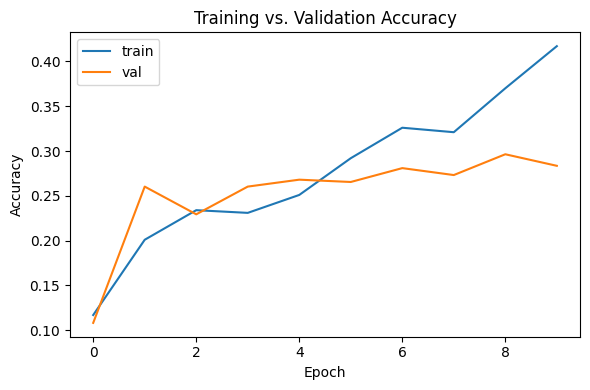

Final validation accuracy: 0.2835

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.1000 - loss: 3.0563 - val_accuracy: 0.1624 - val_loss: 2.2846
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.1676 - loss: 2.2424 - val_accuracy: 0.2294 - val_loss: 2.0979
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.1947 - loss: 2.0977 - val_accuracy: 0.2448 - val_loss: 2.0463
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.2251 - loss: 2.0435 - val_accuracy: 0.2655 - val_loss: 2.0266
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.2465 - loss: 1.9870 - val_accuracy: 0.2474 - val_loss: 2.0025
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.2731 - loss: 1.9208 - val_accuracy: 0.2552 - val_loss: 1.9895
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1

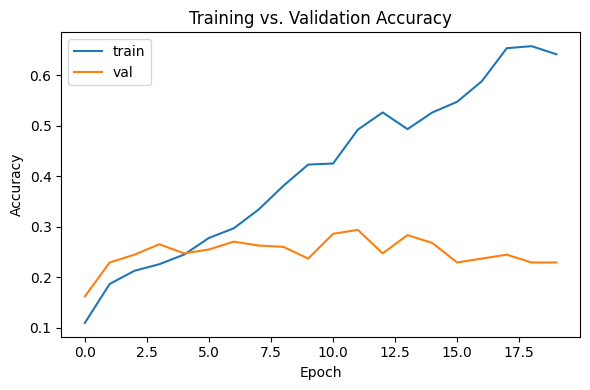

Final validation accuracy: 0.2294

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.1445 - loss: 2.2837 - val_accuracy: 0.1933 - val_loss: 2.1496
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.2272 - loss: 2.1238 - val_accuracy: 0.2010 - val_loss: 2.0753
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.2480 - loss: 2.0637 - val_accuracy: 0.2242 - val_loss: 2.0229
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.2698 - loss: 1.9879 - val_accuracy: 0.2474 - val_loss: 1.9902
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.3158 - loss: 1.9205 - val_accuracy: 0.2474 - val_loss: 1.9948
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.3205 - loss: 1.8806 - val_accuracy: 0.2320 - val_loss: 1.9831
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━

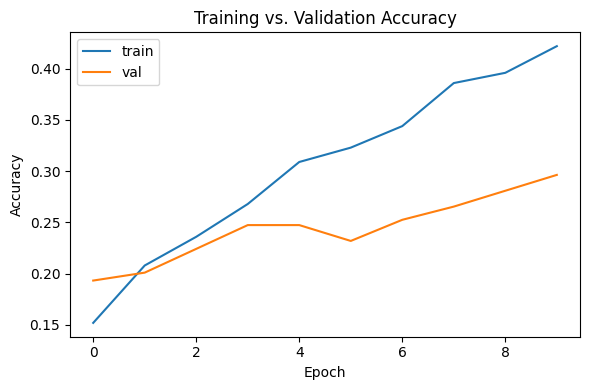

Final validation accuracy: 0.2964

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.1449 - loss: 2.2901 - val_accuracy: 0.1907 - val_loss: 2.1670
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.2246 - loss: 2.1441 - val_accuracy: 0.2216 - val_loss: 2.0587
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.2434 - loss: 2.0690 - val_accuracy: 0.2706 - val_loss: 1.9902
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.2360 - loss: 1.9890 - val_accuracy: 0.2912 - val_loss: 1.9920
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.2856 - loss: 1.9297 - val_accuracy: 0.2577 - val_loss: 1.9943
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.3059 - loss: 1.8929 - val_accuracy: 0.2784 - val_loss: 1.9757
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━

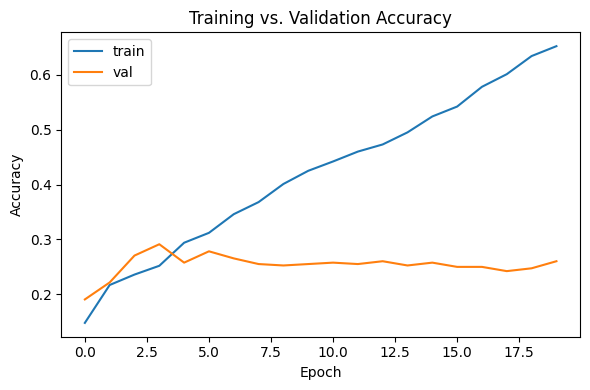

Final validation accuracy: 0.2603

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.0856 - loss: 2.3102 - val_accuracy: 0.0954 - val_loss: 2.3051
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0908 - loss: 2.3065 - val_accuracy: 0.1031 - val_loss: 2.3020
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0940 - loss: 2.3031 - val_accuracy: 0.1057 - val_loss: 2.2992
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1173 - loss: 2.2999 - val_accuracy: 0.1289 - val_loss: 2.2966
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1175 - loss: 2.2970 - val_accuracy: 0.1186 - val_loss: 2.2941
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1256 - loss: 2.2942 - val_accuracy: 0.1263 - val_loss: 2.2917
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 

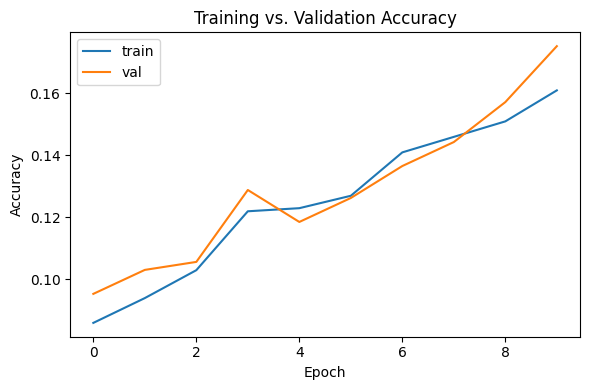

Final validation accuracy: 0.1753

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0926 - loss: 2.3045 - val_accuracy: 0.0954 - val_loss: 2.2950
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0910 - loss: 2.3018 - val_accuracy: 0.0979 - val_loss: 2.2934
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1055 - loss: 2.2993 - val_accuracy: 0.1057 - val_loss: 2.2919
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1197 - loss: 2.2969 - val_accuracy: 0.1186 - val_loss: 2.2904
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1489 - loss: 2.2945 - val_accuracy: 0.1263 - val_loss: 2.2889
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1541 - loss: 2.2922 - val_accuracy: 0.1469 - val_loss: 2.2874
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

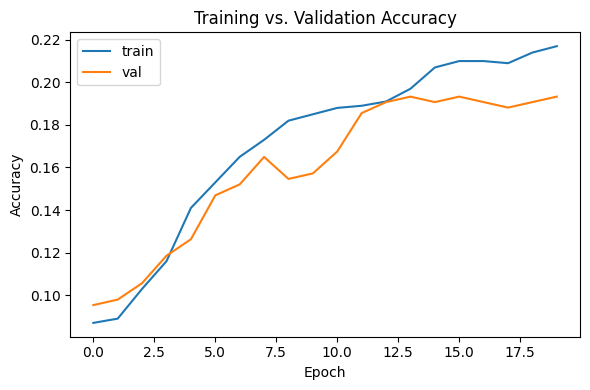

Final validation accuracy: 0.1933

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1007 - loss: 2.3050 - val_accuracy: 0.0876 - val_loss: 2.3061
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1010 - loss: 2.3046 - val_accuracy: 0.0851 - val_loss: 2.3058
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1003 - loss: 2.3042 - val_accuracy: 0.0825 - val_loss: 2.3054
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1010 - loss: 2.3039 - val_accuracy: 0.0825 - val_loss: 2.3051
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1009 - loss: 2.3035 - val_accuracy: 0.0902 - val_loss: 2.3047
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1005 - loss: 2.3031 - val_accuracy: 0.0851 - val_loss: 2.3044
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

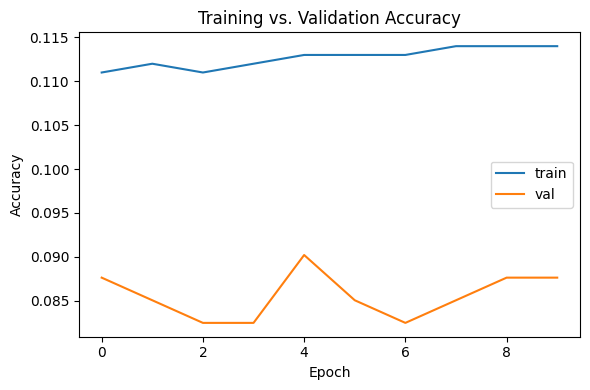

Final validation accuracy: 0.0876

Testing: hidden_layer_sizes=[1024, 512], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1246 - loss: 2.3077 - val_accuracy: 0.1057 - val_loss: 2.2969
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1258 - loss: 2.3073 - val_accuracy: 0.1082 - val_loss: 2.2967
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1243 - loss: 2.3069 - val_accuracy: 0.1108 - val_loss: 2.2965
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1229 - loss: 2.3066 - val_accuracy: 0.1108 - val_loss: 2.2963
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1222 - loss: 2.3062 - val_accuracy: 0.1108 - val_loss: 2.2961
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1222 - loss: 2.3058 - val_accuracy: 0.1134 - val_loss: 2.2959
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

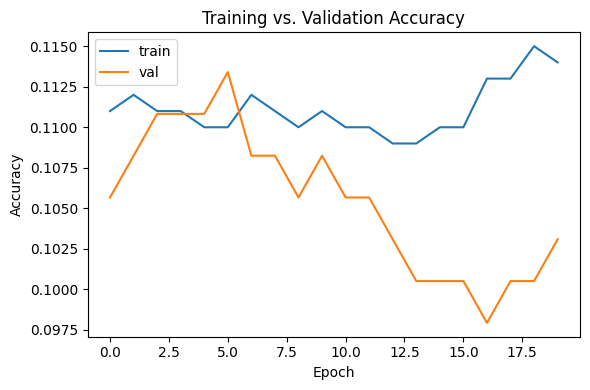

Final validation accuracy: 0.1031

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.1033 - loss: 2.3799 - val_accuracy: 0.1314 - val_loss: 2.2201
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.2045 - loss: 2.1883 - val_accuracy: 0.1675 - val_loss: 2.1811
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.1704 - loss: 2.1523 - val_accuracy: 0.1649 - val_loss: 2.1439
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.1871 - loss: 2.1278 - val_accuracy: 0.1495 - val_loss: 2.1638
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.1614 - loss: 2.1212 - val_accuracy: 0.1495 - val_loss: 2.1471
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.1795 - loss: 2.1076 - val_accuracy: 0.1598 - val_loss: 2.1354
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

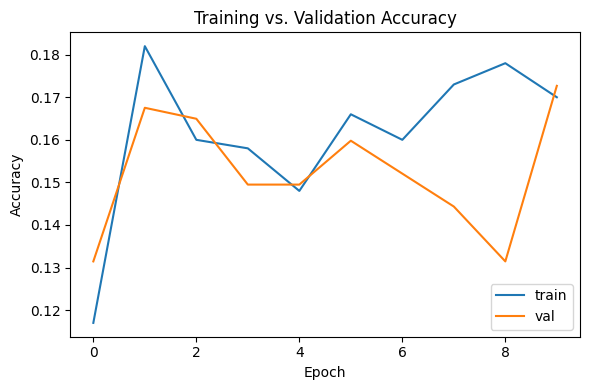

Final validation accuracy: 0.1727

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.1023 - loss: 2.3584 - val_accuracy: 0.1907 - val_loss: 2.2074
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.1684 - loss: 2.1731 - val_accuracy: 0.2062 - val_loss: 2.1484
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.1712 - loss: 2.1323 - val_accuracy: 0.1727 - val_loss: 2.1710
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.1921 - loss: 2.1359 - val_accuracy: 0.1572 - val_loss: 2.1801
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.1770 - loss: 2.1147 - val_accuracy: 0.1598 - val_loss: 2.1418
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.1898 - loss: 2.0872 - val_accuracy: 0.1443 - val_loss: 2.1789
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

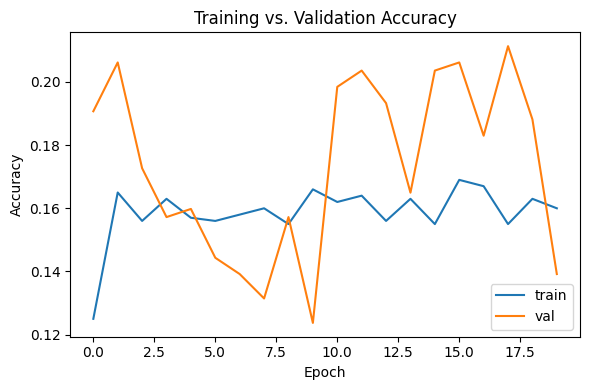

Final validation accuracy: 0.1392

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.1255 - loss: 2.3223 - val_accuracy: 0.1314 - val_loss: 2.2080
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.1979 - loss: 2.1502 - val_accuracy: 0.2448 - val_loss: 2.0607
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.2709 - loss: 2.0372 - val_accuracy: 0.2371 - val_loss: 2.0120
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.2879 - loss: 1.9744 - val_accuracy: 0.2268 - val_loss: 2.0002
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3187 - loss: 1.9170 - val_accuracy: 0.2706 - val_loss: 1.9742
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3508 - loss: 1.8532 - val_accuracy: 0.2758 - val_loss: 1.9580
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1

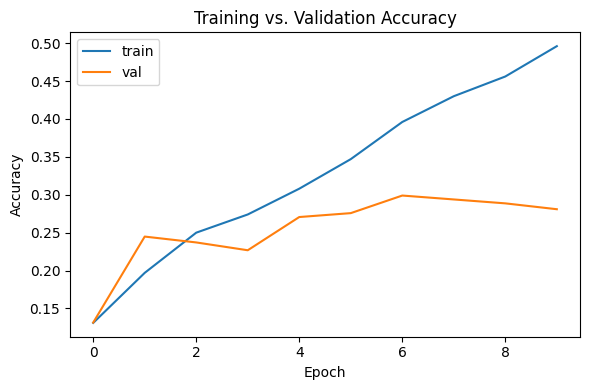

Final validation accuracy: 0.2809

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.1333 - loss: 2.3231 - val_accuracy: 0.1624 - val_loss: 2.1913
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.2221 - loss: 2.1404 - val_accuracy: 0.2423 - val_loss: 2.0644
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.2693 - loss: 2.0378 - val_accuracy: 0.2423 - val_loss: 2.0248
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.3061 - loss: 1.9706 - val_accuracy: 0.2294 - val_loss: 2.0053
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.3174 - loss: 1.9140 - val_accuracy: 0.2500 - val_loss: 1.9861
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3521 - loss: 1.8556 - val_accuracy: 0.2655 - val_loss: 1.9739
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1

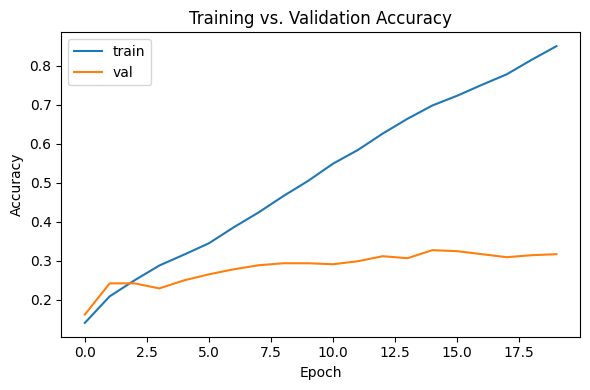

Final validation accuracy: 0.3170

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1072 - loss: 2.3065 - val_accuracy: 0.1186 - val_loss: 2.3121
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1069 - loss: 2.3003 - val_accuracy: 0.1263 - val_loss: 2.3044
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1175 - loss: 2.2947 - val_accuracy: 0.1263 - val_loss: 2.2976
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1356 - loss: 2.2897 - val_accuracy: 0.1314 - val_loss: 2.2916
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1370 - loss: 2.2849 - val_accuracy: 0.1366 - val_loss: 2.2861
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1494 - loss: 2.2803 - val_accuracy: 0.1495 - val_loss: 2.2809
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

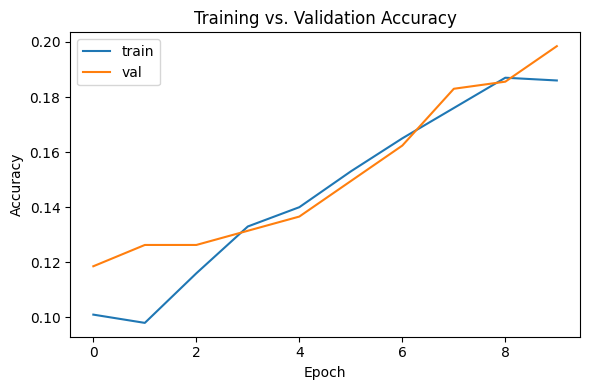

Final validation accuracy: 0.1985

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0726 - loss: 2.3266 - val_accuracy: 0.0876 - val_loss: 2.3258
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0846 - loss: 2.3181 - val_accuracy: 0.0799 - val_loss: 2.3172
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0808 - loss: 2.3111 - val_accuracy: 0.0670 - val_loss: 2.3099
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0974 - loss: 2.3049 - val_accuracy: 0.0670 - val_loss: 2.3035
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1157 - loss: 2.2994 - val_accuracy: 0.0902 - val_loss: 2.2977
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1266 - loss: 2.2943 - val_accuracy: 0.1160 - val_loss: 2.2924
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

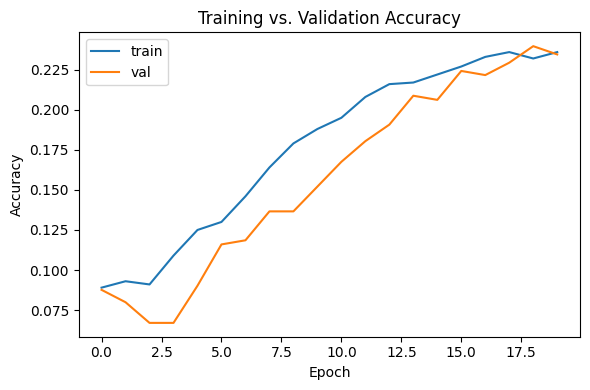

Final validation accuracy: 0.2345

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1241 - loss: 2.3066 - val_accuracy: 0.0747 - val_loss: 2.3272
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1234 - loss: 2.3059 - val_accuracy: 0.0773 - val_loss: 2.3260
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1279 - loss: 2.3052 - val_accuracy: 0.0747 - val_loss: 2.3249
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1279 - loss: 2.3045 - val_accuracy: 0.0747 - val_loss: 2.3238
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1279 - loss: 2.3039 - val_accuracy: 0.0747 - val_loss: 2.3227
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1280 - loss: 2.3032 - val_accuracy: 0.0747 - val_loss: 2.3216
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

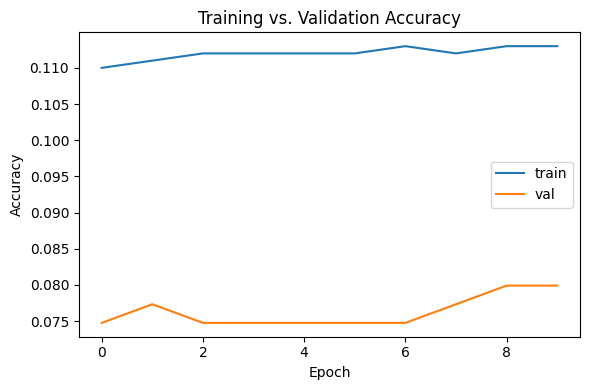

Final validation accuracy: 0.0799

Testing: hidden_layer_sizes=[1024, 512], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1073 - loss: 2.3067 - val_accuracy: 0.1495 - val_loss: 2.2998
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1069 - loss: 2.3062 - val_accuracy: 0.1521 - val_loss: 2.2994
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1067 - loss: 2.3057 - val_accuracy: 0.1521 - val_loss: 2.2989
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1058 - loss: 2.3052 - val_accuracy: 0.1546 - val_loss: 2.2985
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1078 - loss: 2.3047 - val_accuracy: 0.1572 - val_loss: 2.2981
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1060 - loss: 2.3042 - val_accuracy: 0.1572 - val_loss: 2.2977
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

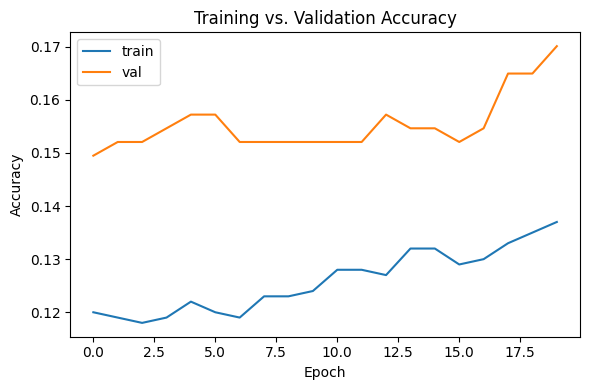

Final validation accuracy: 0.1701

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1048 - loss: 2.4584 - val_accuracy: 0.1237 - val_loss: 2.2316
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1651 - loss: 2.1543 - val_accuracy: 0.2036 - val_loss: 2.1216
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1961 - loss: 2.0865 - val_accuracy: 0.2320 - val_loss: 2.0264
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2006 - loss: 2.0399 - val_accuracy: 0.2191 - val_loss: 2.0242
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2689 - loss: 1.9708 - val_accuracy: 0.2423 - val_loss: 1.9821
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3077 - loss: 1.9051 - val_accuracy: 0.2474 - val_loss: 2.0123
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 

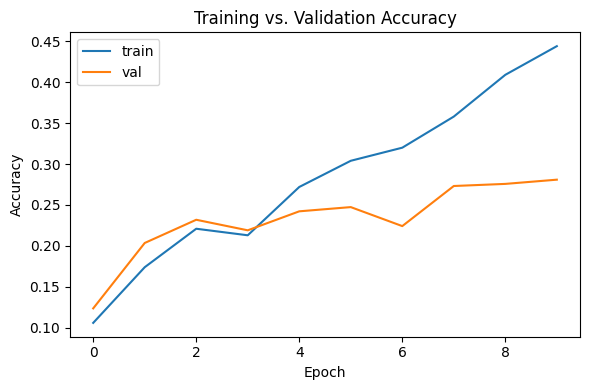

Final validation accuracy: 0.2809

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1106 - loss: 2.4959 - val_accuracy: 0.1443 - val_loss: 2.1642
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1837 - loss: 2.1421 - val_accuracy: 0.1907 - val_loss: 2.0672
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2356 - loss: 2.0455 - val_accuracy: 0.2294 - val_loss: 2.0639
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2478 - loss: 2.0027 - val_accuracy: 0.2629 - val_loss: 2.0030
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2988 - loss: 1.9309 - val_accuracy: 0.2680 - val_loss: 1.9968
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3378 - loss: 1.8740 - val_accuracy: 0.2938 - val_loss: 1.9866
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 

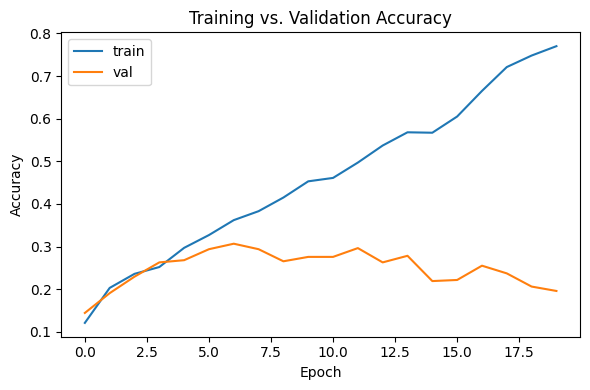

Final validation accuracy: 0.1959

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.1237 - loss: 2.2941 - val_accuracy: 0.1701 - val_loss: 2.2149
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2136 - loss: 2.1991 - val_accuracy: 0.1804 - val_loss: 2.1106
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2396 - loss: 2.0987 - val_accuracy: 0.2371 - val_loss: 2.0366
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2659 - loss: 2.0303 - val_accuracy: 0.2526 - val_loss: 1.9947
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2930 - loss: 1.9894 - val_accuracy: 0.2526 - val_loss: 1.9827
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3021 - loss: 1.9548 - val_accuracy: 0.2655 - val_loss: 1.9743
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

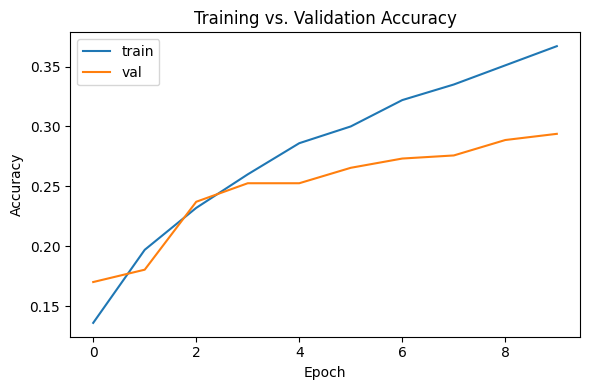

Final validation accuracy: 0.2938

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1218 - loss: 2.2965 - val_accuracy: 0.1753 - val_loss: 2.2261
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1997 - loss: 2.2011 - val_accuracy: 0.1778 - val_loss: 2.1181
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2257 - loss: 2.1051 - val_accuracy: 0.2165 - val_loss: 2.0425
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2449 - loss: 2.0375 - val_accuracy: 0.2242 - val_loss: 2.0134
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2823 - loss: 1.9968 - val_accuracy: 0.2732 - val_loss: 1.9909
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2926 - loss: 1.9617 - val_accuracy: 0.2732 - val_loss: 1.9759
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

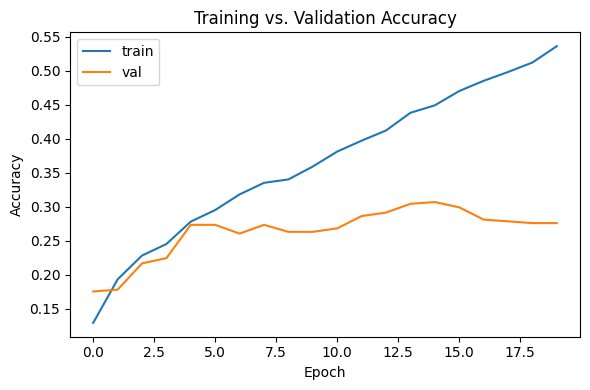

Final validation accuracy: 0.2758

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0964 - loss: 2.3052 - val_accuracy: 0.0979 - val_loss: 2.3032
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0972 - loss: 2.3037 - val_accuracy: 0.0979 - val_loss: 2.3018
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1029 - loss: 2.3022 - val_accuracy: 0.1005 - val_loss: 2.3004
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1038 - loss: 2.3007 - val_accuracy: 0.1005 - val_loss: 2.2990
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1088 - loss: 2.2993 - val_accuracy: 0.1057 - val_loss: 2.2977
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1163 - loss: 2.2979 - val_accuracy: 0.1160 - val_loss: 2.2964
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1

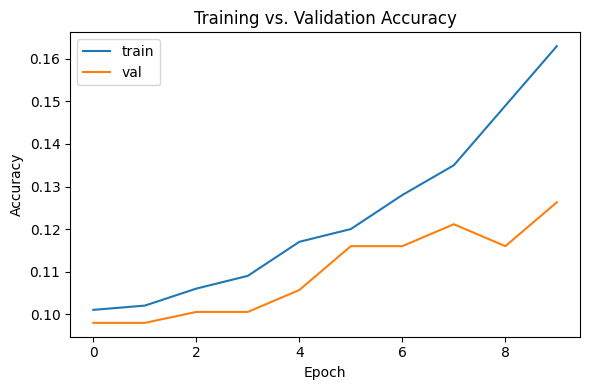

Final validation accuracy: 0.1263

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1067 - loss: 2.3051 - val_accuracy: 0.0979 - val_loss: 2.3090
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1084 - loss: 2.3036 - val_accuracy: 0.0979 - val_loss: 2.3073
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1122 - loss: 2.3022 - val_accuracy: 0.1005 - val_loss: 2.3057
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1191 - loss: 2.3008 - val_accuracy: 0.1057 - val_loss: 2.3041
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1249 - loss: 2.2994 - val_accuracy: 0.1237 - val_loss: 2.3026
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1347 - loss: 2.2981 - val_accuracy: 0.1289 - val_loss: 2.3010
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1

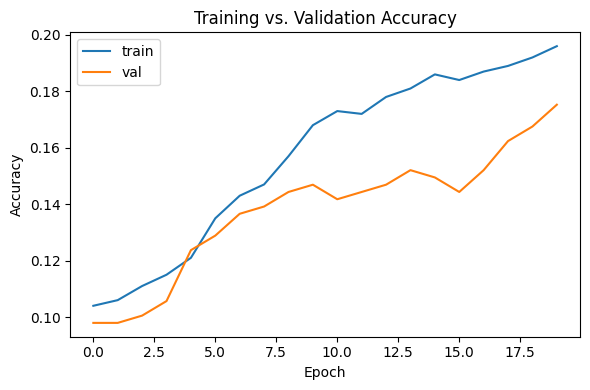

Final validation accuracy: 0.1753

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0882 - loss: 2.3097 - val_accuracy: 0.0851 - val_loss: 2.2934
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0882 - loss: 2.3095 - val_accuracy: 0.0851 - val_loss: 2.2933
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0890 - loss: 2.3093 - val_accuracy: 0.0851 - val_loss: 2.2932
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0890 - loss: 2.3091 - val_accuracy: 0.0851 - val_loss: 2.2931
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0890 - loss: 2.3089 - val_accuracy: 0.0851 - val_loss: 2.2930
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0890 - loss: 2.3087 - val_accuracy: 0.0851 - val_loss: 2.2930
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

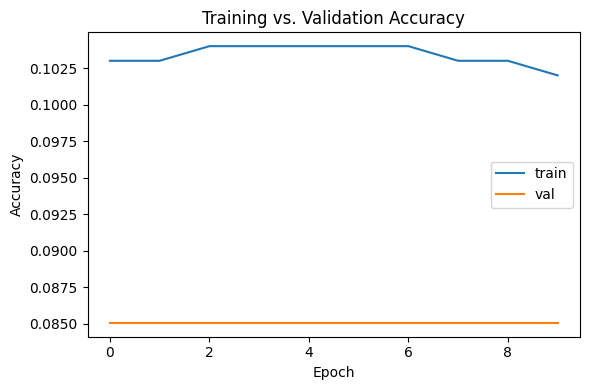

Final validation accuracy: 0.0851

Testing: hidden_layer_sizes=[512, 256], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1075 - loss: 2.3035 - val_accuracy: 0.1418 - val_loss: 2.3040
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1082 - loss: 2.3033 - val_accuracy: 0.1443 - val_loss: 2.3039
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1082 - loss: 2.3031 - val_accuracy: 0.1469 - val_loss: 2.3037
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1086 - loss: 2.3029 - val_accuracy: 0.1495 - val_loss: 2.3035
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1089 - loss: 2.3028 - val_accuracy: 0.1495 - val_loss: 2.3033
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1111 - loss: 2.3026 - val_accuracy: 0.1495 - val_loss: 2.3032
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

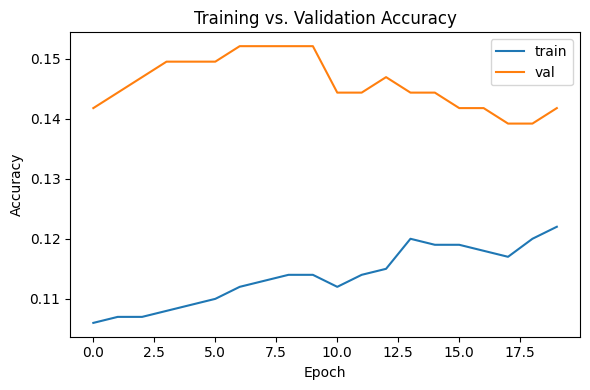

Final validation accuracy: 0.1418

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0845 - loss: 2.3085 - val_accuracy: 0.2191 - val_loss: 2.1821
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1762 - loss: 2.1573 - val_accuracy: 0.2062 - val_loss: 2.1026
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1785 - loss: 2.0929 - val_accuracy: 0.1701 - val_loss: 2.1426
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2062 - loss: 2.0740 - val_accuracy: 0.1624 - val_loss: 2.1540
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2132 - loss: 2.0786 - val_accuracy: 0.1624 - val_loss: 2.1409
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1996 - loss: 2.0603 - val_accuracy: 0.1985 - val_loss: 2.1585
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 

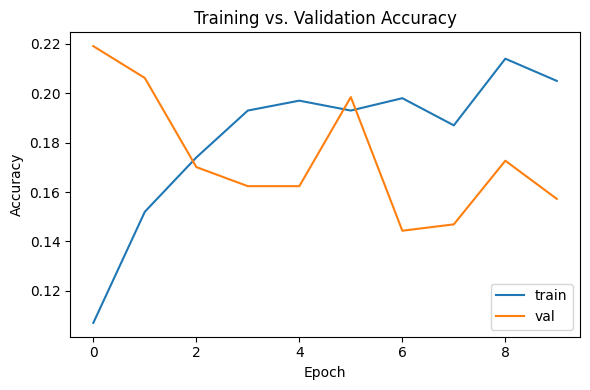

Final validation accuracy: 0.1572

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1203 - loss: 2.3009 - val_accuracy: 0.1572 - val_loss: 2.1771
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1891 - loss: 2.1397 - val_accuracy: 0.1701 - val_loss: 2.1449
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2015 - loss: 2.0870 - val_accuracy: 0.2191 - val_loss: 2.0957
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1778 - loss: 2.0453 - val_accuracy: 0.1985 - val_loss: 2.1473
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1847 - loss: 2.0722 - val_accuracy: 0.1392 - val_loss: 2.1593
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1856 - loss: 2.0747 - val_accuracy: 0.2268 - val_loss: 2.1319
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 

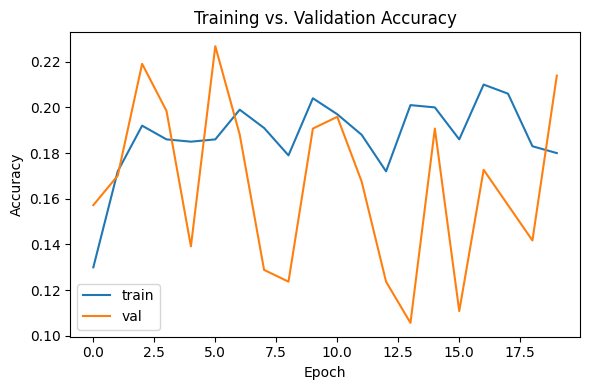

Final validation accuracy: 0.2139

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1155 - loss: 2.3033 - val_accuracy: 0.1985 - val_loss: 2.2121
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2314 - loss: 2.1872 - val_accuracy: 0.2320 - val_loss: 2.1354
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2676 - loss: 2.1009 - val_accuracy: 0.2732 - val_loss: 2.0765
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2941 - loss: 2.0424 - val_accuracy: 0.2706 - val_loss: 2.0387
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3096 - loss: 1.9944 - val_accuracy: 0.2938 - val_loss: 2.0164
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3605 - loss: 1.9483 - val_accuracy: 0.2912 - val_loss: 2.0014
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

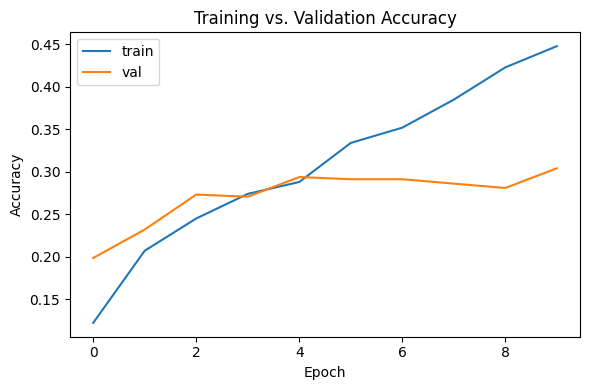

Final validation accuracy: 0.3041

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1242 - loss: 2.3013 - val_accuracy: 0.1778 - val_loss: 2.2258
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2425 - loss: 2.1895 - val_accuracy: 0.1830 - val_loss: 2.1323
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2677 - loss: 2.0940 - val_accuracy: 0.1881 - val_loss: 2.0813
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2789 - loss: 2.0384 - val_accuracy: 0.2294 - val_loss: 2.0421
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3019 - loss: 1.9887 - val_accuracy: 0.2706 - val_loss: 2.0113
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3302 - loss: 1.9433 - val_accuracy: 0.2861 - val_loss: 1.9969
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

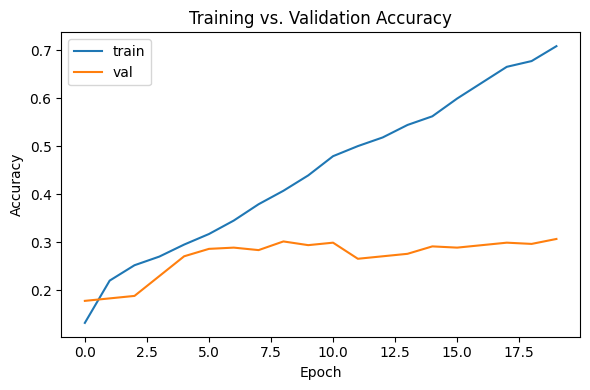

Final validation accuracy: 0.3067

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0945 - loss: 2.3028 - val_accuracy: 0.0876 - val_loss: 2.3047
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0932 - loss: 2.3006 - val_accuracy: 0.0954 - val_loss: 2.3025
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1110 - loss: 2.2985 - val_accuracy: 0.1005 - val_loss: 2.3004
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1185 - loss: 2.2965 - val_accuracy: 0.1082 - val_loss: 2.2984
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1253 - loss: 2.2944 - val_accuracy: 0.1186 - val_loss: 2.2965
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1349 - loss: 2.2925 - val_accuracy: 0.1237 - val_loss: 2.2945
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2

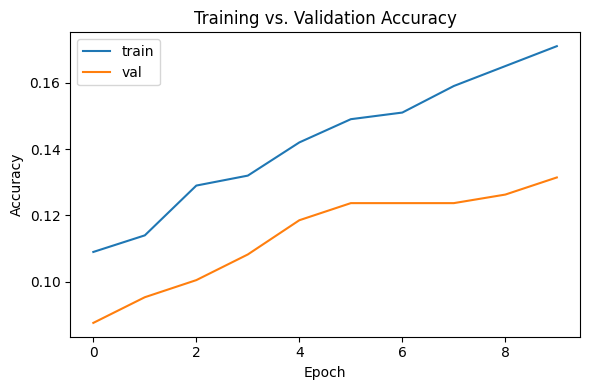

Final validation accuracy: 0.1314

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1299 - loss: 2.3059 - val_accuracy: 0.1546 - val_loss: 2.3028
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1407 - loss: 2.3033 - val_accuracy: 0.1649 - val_loss: 2.3004
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1456 - loss: 2.3008 - val_accuracy: 0.1753 - val_loss: 2.2982
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1528 - loss: 2.2984 - val_accuracy: 0.1856 - val_loss: 2.2960
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1548 - loss: 2.2961 - val_accuracy: 0.1907 - val_loss: 2.2939
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1647 - loss: 2.2938 - val_accuracy: 0.1881 - val_loss: 2.2917
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2

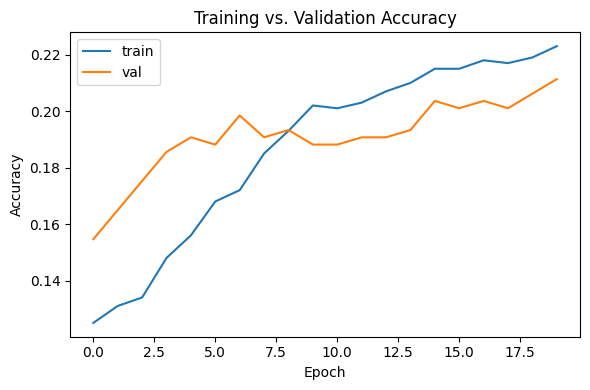

Final validation accuracy: 0.2113

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1050 - loss: 2.3079 - val_accuracy: 0.0851 - val_loss: 2.3209
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1071 - loss: 2.3076 - val_accuracy: 0.0851 - val_loss: 2.3205
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1086 - loss: 2.3073 - val_accuracy: 0.0902 - val_loss: 2.3200
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1080 - loss: 2.3070 - val_accuracy: 0.0902 - val_loss: 2.3196
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1085 - loss: 2.3067 - val_accuracy: 0.0902 - val_loss: 2.3191
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1085 - loss: 2.3065 - val_accuracy: 0.0902 - val_loss: 2.3187
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

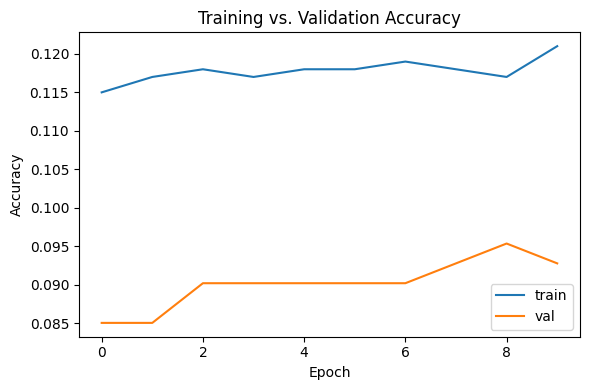

Final validation accuracy: 0.0928

Testing: hidden_layer_sizes=[512, 256], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1112 - loss: 2.3013 - val_accuracy: 0.0799 - val_loss: 2.3076
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1115 - loss: 2.3010 - val_accuracy: 0.0799 - val_loss: 2.3073
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1120 - loss: 2.3007 - val_accuracy: 0.0799 - val_loss: 2.3069
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1120 - loss: 2.3005 - val_accuracy: 0.0799 - val_loss: 2.3066
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1152 - loss: 2.3002 - val_accuracy: 0.0799 - val_loss: 2.3062
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1170 - loss: 2.2999 - val_accuracy: 0.0799 - val_loss: 2.3059
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 

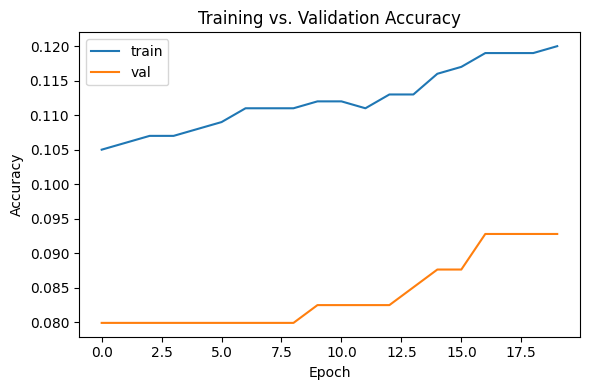

Final validation accuracy: 0.0928

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0923 - loss: 2.5128 - val_accuracy: 0.1804 - val_loss: 2.1708
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1977 - loss: 2.1367 - val_accuracy: 0.2732 - val_loss: 2.0214
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2057 - loss: 2.0652 - val_accuracy: 0.2448 - val_loss: 2.0344
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2290 - loss: 2.0044 - val_accuracy: 0.2165 - val_loss: 2.0325
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2945 - loss: 1.9424 - val_accuracy: 0.2526 - val_loss: 2.0176
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3066 - loss: 1.8883 - val_accuracy: 0.2500 - val_loss: 2.0046
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/

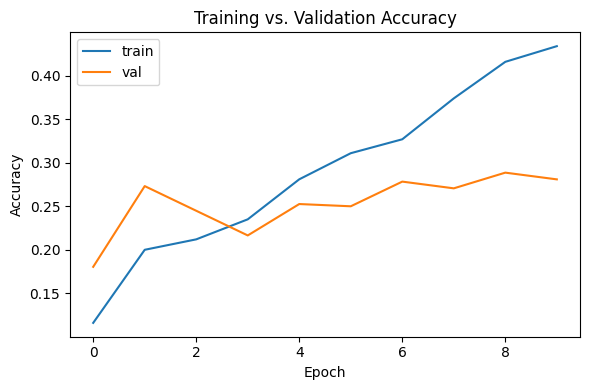

Final validation accuracy: 0.2809

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1270 - loss: 2.4535 - val_accuracy: 0.2062 - val_loss: 2.1461
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2304 - loss: 2.1136 - val_accuracy: 0.1907 - val_loss: 2.0785
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2474 - loss: 2.0536 - val_accuracy: 0.2423 - val_loss: 2.0289
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2672 - loss: 1.9904 - val_accuracy: 0.2629 - val_loss: 1.9831
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2921 - loss: 1.9327 - val_accuracy: 0.2423 - val_loss: 2.0006
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3192 - loss: 1.8656 - val_accuracy: 0.2732 - val_loss: 1.9765
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/

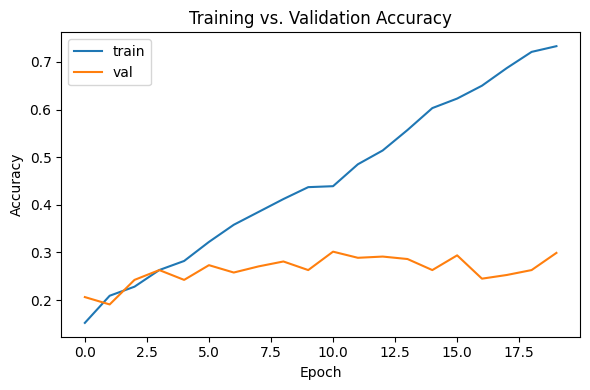

Final validation accuracy: 0.2990

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1201 - loss: 2.3088 - val_accuracy: 0.1546 - val_loss: 2.2731
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2116 - loss: 2.2327 - val_accuracy: 0.2706 - val_loss: 2.1600
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2957 - loss: 2.1426 - val_accuracy: 0.2062 - val_loss: 2.1102
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2983 - loss: 2.0780 - val_accuracy: 0.2216 - val_loss: 2.0668
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3103 - loss: 2.0267 - val_accuracy: 0.2577 - val_loss: 2.0328
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3191 - loss: 1.9848 - val_accuracy: 0.2655 - val_loss: 2.0173
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms

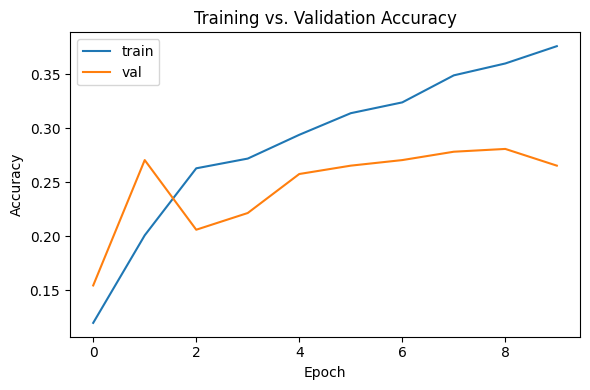

Final validation accuracy: 0.2655

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1580 - loss: 2.2927 - val_accuracy: 0.1031 - val_loss: 2.2396
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1684 - loss: 2.2107 - val_accuracy: 0.1856 - val_loss: 2.1455
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2696 - loss: 2.1080 - val_accuracy: 0.2371 - val_loss: 2.0794
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2973 - loss: 2.0472 - val_accuracy: 0.2320 - val_loss: 2.0531
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3033 - loss: 2.0018 - val_accuracy: 0.2216 - val_loss: 2.0366
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3186 - loss: 1.9668 - val_accuracy: 0.2423 - val_loss: 2.0220
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms

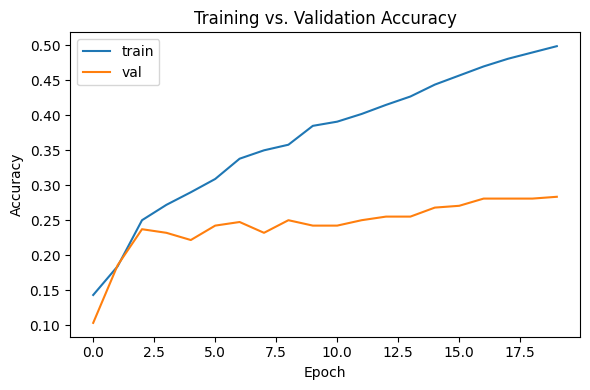

Final validation accuracy: 0.2835

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0848 - loss: 2.3138 - val_accuracy: 0.0825 - val_loss: 2.2983
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0883 - loss: 2.3104 - val_accuracy: 0.0851 - val_loss: 2.2965
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0821 - loss: 2.3073 - val_accuracy: 0.0876 - val_loss: 2.2948
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0846 - loss: 2.3045 - val_accuracy: 0.0979 - val_loss: 2.2932
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1041 - loss: 2.3019 - val_accuracy: 0.1005 - val_loss: 2.2916
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1082 - loss: 2.2995 - val_accuracy: 0.1031 - val_loss: 2.2900
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/s

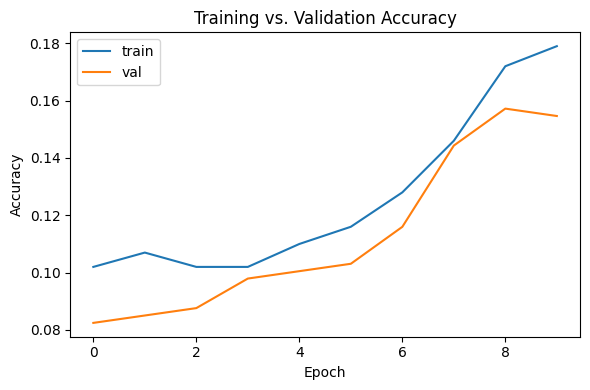

Final validation accuracy: 0.1546

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0900 - loss: 2.3050 - val_accuracy: 0.0928 - val_loss: 2.3008
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0979 - loss: 2.3023 - val_accuracy: 0.1005 - val_loss: 2.2990
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1013 - loss: 2.2998 - val_accuracy: 0.1057 - val_loss: 2.2973
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1080 - loss: 2.2974 - val_accuracy: 0.1211 - val_loss: 2.2957
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1284 - loss: 2.2952 - val_accuracy: 0.1314 - val_loss: 2.2940
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1392 - loss: 2.2929 - val_accuracy: 0.1521 - val_loss: 2.2923
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/s

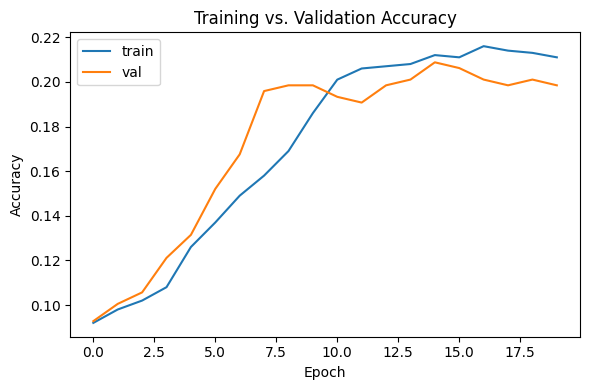

Final validation accuracy: 0.1985

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0931 - loss: 2.3058 - val_accuracy: 0.1186 - val_loss: 2.2872
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0919 - loss: 2.3055 - val_accuracy: 0.1186 - val_loss: 2.2871
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0932 - loss: 2.3052 - val_accuracy: 0.1160 - val_loss: 2.2871
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0936 - loss: 2.3050 - val_accuracy: 0.1160 - val_loss: 2.2870
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0933 - loss: 2.3047 - val_accuracy: 0.1160 - val_loss: 2.2870
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0924 - loss: 2.3044 - val_accuracy: 0.1186 - val_loss: 2.2870
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

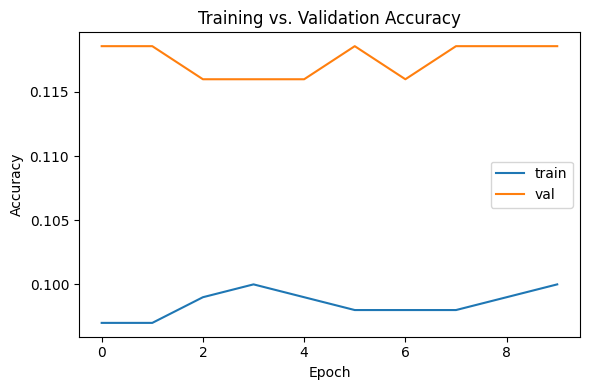

Final validation accuracy: 0.1186

Testing: hidden_layer_sizes=[256], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1071 - loss: 2.3037 - val_accuracy: 0.1186 - val_loss: 2.2985
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1054 - loss: 2.3034 - val_accuracy: 0.1186 - val_loss: 2.2984
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1062 - loss: 2.3032 - val_accuracy: 0.1237 - val_loss: 2.2982
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1063 - loss: 2.3030 - val_accuracy: 0.1237 - val_loss: 2.2980
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1052 - loss: 2.3027 - val_accuracy: 0.1237 - val_loss: 2.2979
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1034 - loss: 2.3025 - val_accuracy: 0.1263 - val_loss: 2.2977
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

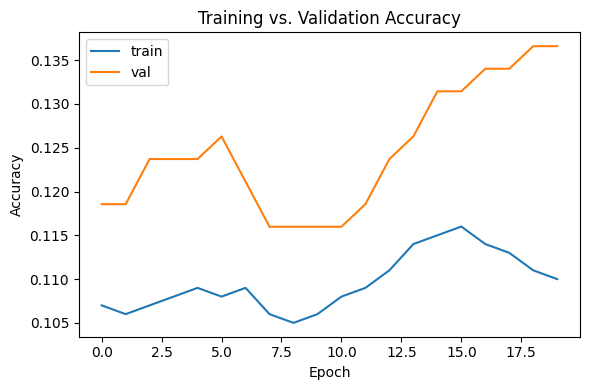

Final validation accuracy: 0.1366

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1081 - loss: 2.3542 - val_accuracy: 0.0979 - val_loss: 2.2527
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1346 - loss: 2.2505 - val_accuracy: 0.1598 - val_loss: 2.1649
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2003 - loss: 2.1500 - val_accuracy: 0.2216 - val_loss: 2.1234
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2130 - loss: 2.1110 - val_accuracy: 0.2268 - val_loss: 2.0907
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2418 - loss: 2.0724 - val_accuracy: 0.2655 - val_loss: 2.0817
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2395 - loss: 2.0637 - val_accuracy: 0.2191 - val_loss: 2.0848
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/

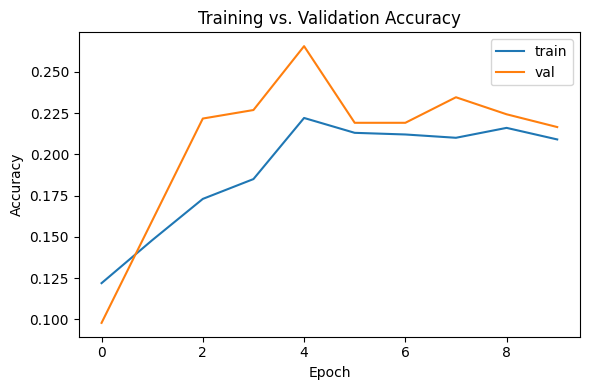

Final validation accuracy: 0.2165

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1198 - loss: 2.3392 - val_accuracy: 0.1031 - val_loss: 2.2547
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1335 - loss: 2.2257 - val_accuracy: 0.1701 - val_loss: 2.1448
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2167 - loss: 2.1271 - val_accuracy: 0.2577 - val_loss: 2.1055
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1876 - loss: 2.1019 - val_accuracy: 0.2216 - val_loss: 2.0953
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1998 - loss: 2.0703 - val_accuracy: 0.1727 - val_loss: 2.0712
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2104 - loss: 2.0424 - val_accuracy: 0.2655 - val_loss: 2.0571
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/

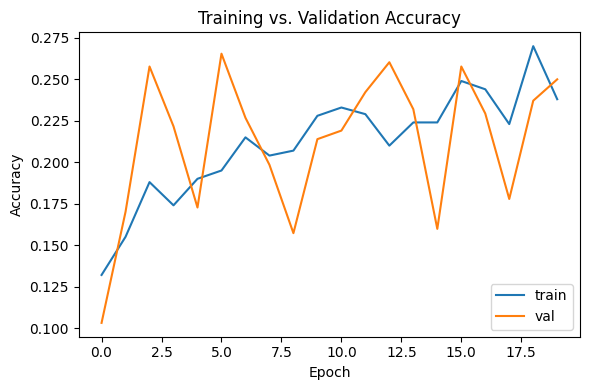

Final validation accuracy: 0.2500

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1199 - loss: 2.3042 - val_accuracy: 0.1186 - val_loss: 2.2232
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1860 - loss: 2.1935 - val_accuracy: 0.2397 - val_loss: 2.1345
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2850 - loss: 2.0992 - val_accuracy: 0.2577 - val_loss: 2.0847
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2961 - loss: 2.0440 - val_accuracy: 0.2784 - val_loss: 2.0558
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3147 - loss: 2.0002 - val_accuracy: 0.2706 - val_loss: 2.0357
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3398 - loss: 1.9606 - val_accuracy: 0.2706 - val_loss: 2.0278
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms

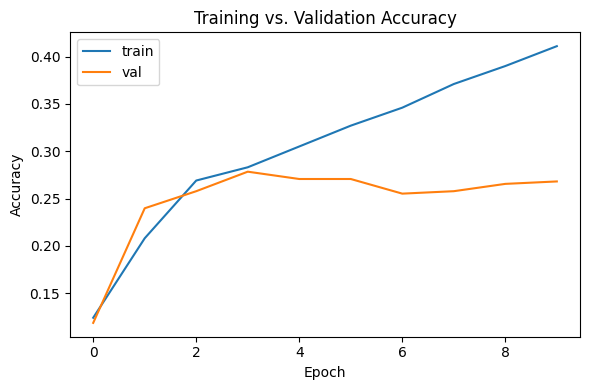

Final validation accuracy: 0.2680

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1495 - loss: 2.3007 - val_accuracy: 0.1057 - val_loss: 2.2375
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1763 - loss: 2.2049 - val_accuracy: 0.2758 - val_loss: 2.1477
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3022 - loss: 2.1106 - val_accuracy: 0.2500 - val_loss: 2.0937
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3127 - loss: 2.0517 - val_accuracy: 0.2448 - val_loss: 2.0584
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3182 - loss: 2.0069 - val_accuracy: 0.2732 - val_loss: 2.0288
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3360 - loss: 1.9621 - val_accuracy: 0.2809 - val_loss: 2.0204
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms

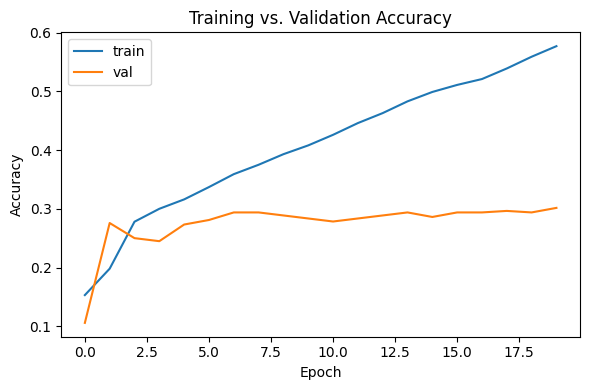

Final validation accuracy: 0.3015

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0953 - loss: 2.3062 - val_accuracy: 0.1314 - val_loss: 2.2969
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0938 - loss: 2.3031 - val_accuracy: 0.1314 - val_loss: 2.2944
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0974 - loss: 2.3002 - val_accuracy: 0.1211 - val_loss: 2.2921
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1098 - loss: 2.2975 - val_accuracy: 0.1392 - val_loss: 2.2898
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1264 - loss: 2.2948 - val_accuracy: 0.1469 - val_loss: 2.2875
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1361 - loss: 2.2923 - val_accuracy: 0.1572 - val_loss: 2.2853
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/s

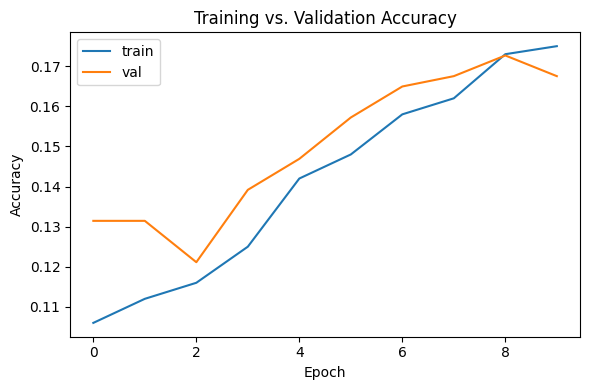

Final validation accuracy: 0.1675

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0977 - loss: 2.3057 - val_accuracy: 0.1211 - val_loss: 2.2959
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1003 - loss: 2.3028 - val_accuracy: 0.1418 - val_loss: 2.2939
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1045 - loss: 2.3001 - val_accuracy: 0.1469 - val_loss: 2.2919
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1132 - loss: 2.2975 - val_accuracy: 0.1469 - val_loss: 2.2899
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1274 - loss: 2.2949 - val_accuracy: 0.1598 - val_loss: 2.2880
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1470 - loss: 2.2925 - val_accuracy: 0.1546 - val_loss: 2.2860
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

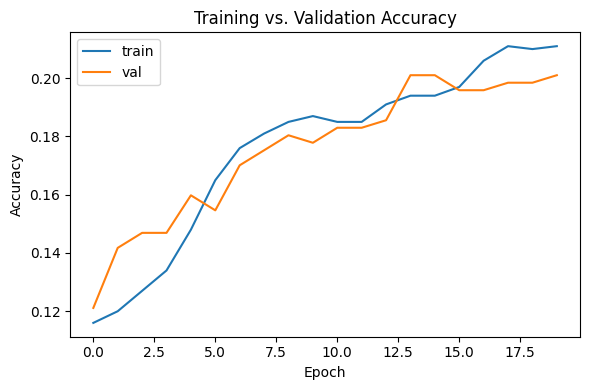

Final validation accuracy: 0.2010

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0784 - loss: 2.3159 - val_accuracy: 0.0747 - val_loss: 2.3076
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0848 - loss: 2.3155 - val_accuracy: 0.0747 - val_loss: 2.3072
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0860 - loss: 2.3150 - val_accuracy: 0.0747 - val_loss: 2.3069
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0888 - loss: 2.3146 - val_accuracy: 0.0747 - val_loss: 2.3065
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0856 - loss: 2.3142 - val_accuracy: 0.0747 - val_loss: 2.3061
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0848 - loss: 2.3138 - val_accuracy: 0.0747 - val_loss: 2.3058
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/

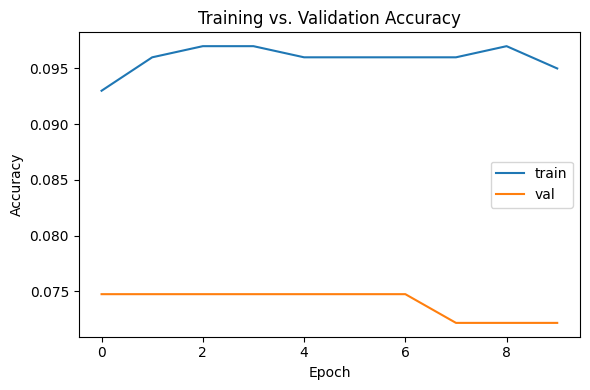

Final validation accuracy: 0.0722

Testing: hidden_layer_sizes=[256], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0791 - loss: 2.3083 - val_accuracy: 0.0567 - val_loss: 2.3040
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0786 - loss: 2.3080 - val_accuracy: 0.0541 - val_loss: 2.3037
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0793 - loss: 2.3078 - val_accuracy: 0.0515 - val_loss: 2.3035
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0776 - loss: 2.3075 - val_accuracy: 0.0515 - val_loss: 2.3032
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0773 - loss: 2.3073 - val_accuracy: 0.0515 - val_loss: 2.3030
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0773 - loss: 2.3070 - val_accuracy: 0.0541 - val_loss: 2.3028
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

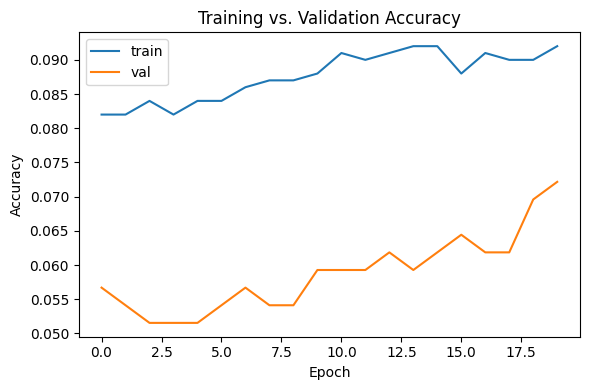

Final validation accuracy: 0.0722

Testing: hidden_layer_sizes=[], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1012 - loss: 4.1626 - val_accuracy: 0.2010 - val_loss: 2.7113
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2081 - loss: 2.3383 - val_accuracy: 0.2577 - val_loss: 2.1527
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3548 - loss: 1.8566 - val_accuracy: 0.2603 - val_loss: 2.0018
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3836 - loss: 1.7294 - val_accuracy: 0.2655 - val_loss: 2.0253
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4409 - loss: 1.6402 - val_accuracy: 0.2758 - val_loss: 2.0498
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4634 - loss: 1.5910 - val_accuracy: 0.2835 - val_loss: 2.0308
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - ac

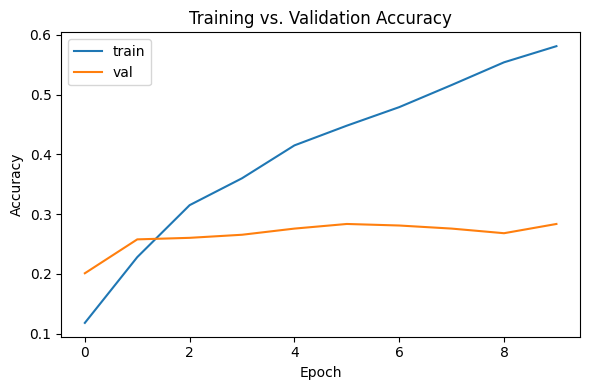

Final validation accuracy: 0.2835

Testing: hidden_layer_sizes=[], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1264 - loss: 3.8320 - val_accuracy: 0.1881 - val_loss: 2.3885
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2573 - loss: 2.1707 - val_accuracy: 0.2706 - val_loss: 2.1735
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2747 - loss: 2.0396 - val_accuracy: 0.2474 - val_loss: 2.0823
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3784 - loss: 1.7785 - val_accuracy: 0.2165 - val_loss: 2.1037
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3880 - loss: 1.7173 - val_accuracy: 0.2732 - val_loss: 2.0486
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4337 - loss: 1.6342 - val_accuracy: 0.2835 - val_loss: 2.0470
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - ac

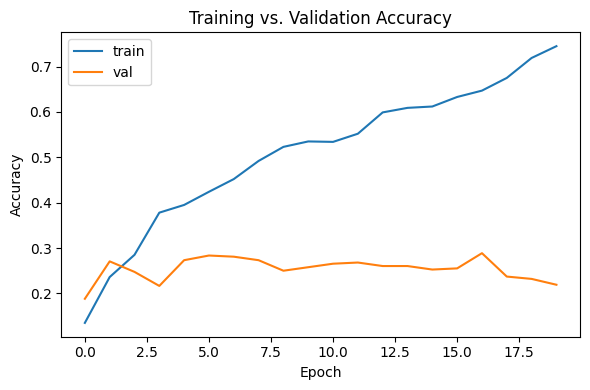

Final validation accuracy: 0.2191

Testing: hidden_layer_sizes=[], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0997 - loss: 2.4079 - val_accuracy: 0.1495 - val_loss: 2.2640
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1965 - loss: 2.1818 - val_accuracy: 0.1624 - val_loss: 2.1974
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2242 - loss: 2.1180 - val_accuracy: 0.1907 - val_loss: 2.1140
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2552 - loss: 2.0322 - val_accuracy: 0.1959 - val_loss: 2.0901
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2934 - loss: 1.9832 - val_accuracy: 0.2036 - val_loss: 2.0787
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3095 - loss: 1.9473 - val_accuracy: 0.2113 - val_loss: 2.0675
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - a

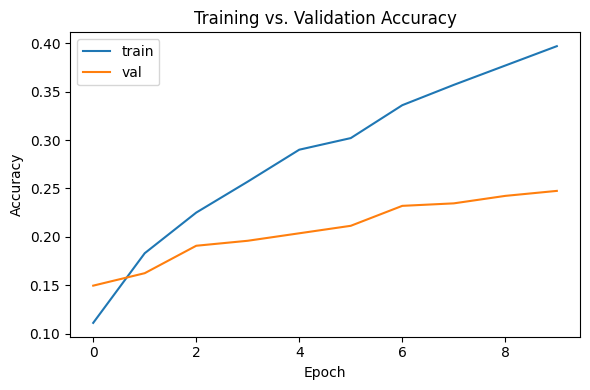

Final validation accuracy: 0.2474

Testing: hidden_layer_sizes=[], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1268 - loss: 2.3657 - val_accuracy: 0.1881 - val_loss: 2.1962
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1856 - loss: 2.1962 - val_accuracy: 0.2036 - val_loss: 2.1244
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2171 - loss: 2.1096 - val_accuracy: 0.2242 - val_loss: 2.0983
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2582 - loss: 2.0259 - val_accuracy: 0.2113 - val_loss: 2.0682
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2843 - loss: 1.9823 - val_accuracy: 0.2139 - val_loss: 2.0562
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3033 - loss: 1.9450 - val_accuracy: 0.2216 - val_loss: 2.0466
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - a

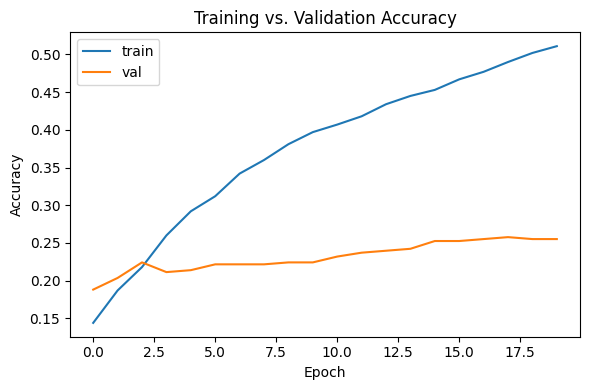

Final validation accuracy: 0.2552

Testing: hidden_layer_sizes=[], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0981 - loss: 2.3690 - val_accuracy: 0.1108 - val_loss: 2.3009
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1371 - loss: 2.2788 - val_accuracy: 0.1314 - val_loss: 2.2573
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1675 - loss: 2.2353 - val_accuracy: 0.1469 - val_loss: 2.2219
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1758 - loss: 2.1990 - val_accuracy: 0.1624 - val_loss: 2.1933
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1899 - loss: 2.1682 - val_accuracy: 0.1881 - val_loss: 2.1697
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2042 - loss: 2.1414 - val_accuracy: 0.2010 - val_loss: 2.1501
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

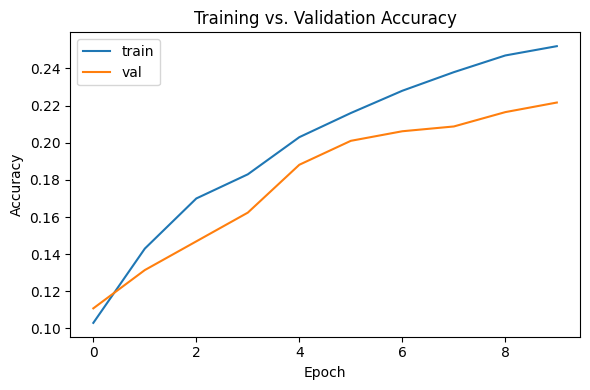

Final validation accuracy: 0.2216

Testing: hidden_layer_sizes=[], activation=relu, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1261 - loss: 2.3268 - val_accuracy: 0.1005 - val_loss: 2.2956
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1458 - loss: 2.2622 - val_accuracy: 0.1263 - val_loss: 2.2535
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1698 - loss: 2.2202 - val_accuracy: 0.1366 - val_loss: 2.2198
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1981 - loss: 2.1849 - val_accuracy: 0.1753 - val_loss: 2.1926
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2083 - loss: 2.1547 - val_accuracy: 0.1881 - val_loss: 2.1701
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2196 - loss: 2.1284 - val_accuracy: 0.1985 - val_loss: 2.1513
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

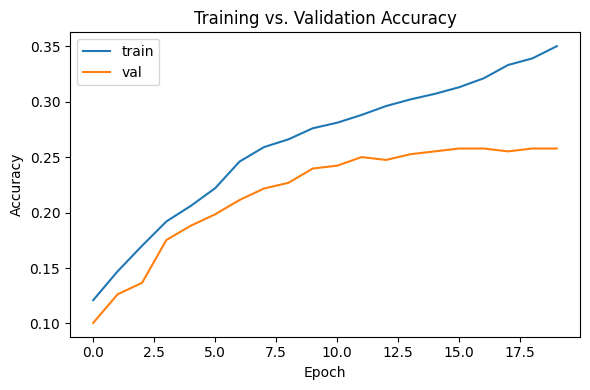

Final validation accuracy: 0.2577

Testing: hidden_layer_sizes=[], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0877 - loss: 2.4441 - val_accuracy: 0.0954 - val_loss: 2.3850
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1092 - loss: 2.3785 - val_accuracy: 0.1005 - val_loss: 2.3407
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1097 - loss: 2.3441 - val_accuracy: 0.1057 - val_loss: 2.3146
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1178 - loss: 2.3239 - val_accuracy: 0.1237 - val_loss: 2.2979
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1318 - loss: 2.3107 - val_accuracy: 0.1211 - val_loss: 2.2863
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1392 - loss: 2.3011 - val_accuracy: 0.1211 - val_loss: 2.2775
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

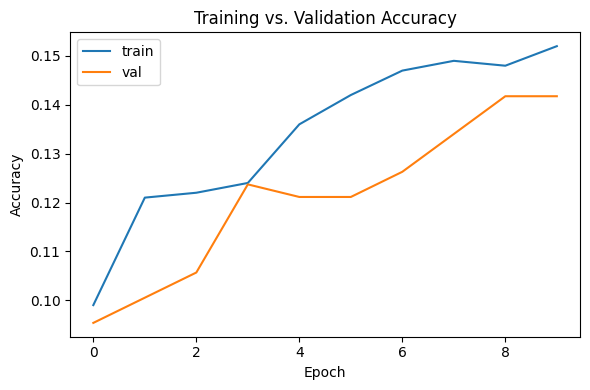

Final validation accuracy: 0.1418

Testing: hidden_layer_sizes=[], activation=relu, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1397 - loss: 2.3528 - val_accuracy: 0.1340 - val_loss: 2.3245
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1446 - loss: 2.3127 - val_accuracy: 0.1289 - val_loss: 2.2978
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1418 - loss: 2.2918 - val_accuracy: 0.1366 - val_loss: 2.2833
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1585 - loss: 2.2802 - val_accuracy: 0.1521 - val_loss: 2.2748
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1558 - loss: 2.2730 - val_accuracy: 0.1521 - val_loss: 2.2690
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1629 - loss: 2.2678 - val_accuracy: 0.1572 - val_loss: 2.2644
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

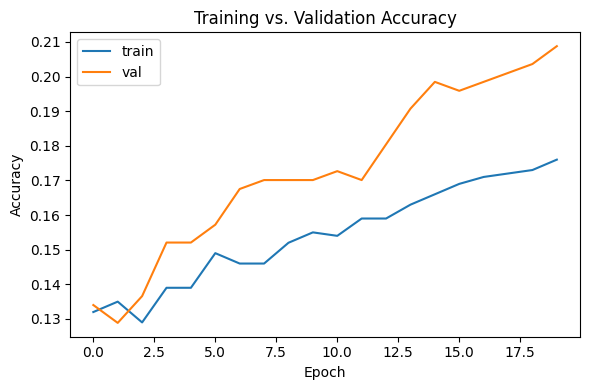

Final validation accuracy: 0.2088

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1092 - loss: 4.4542 - val_accuracy: 0.2036 - val_loss: 2.4878
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2280 - loss: 2.6082 - val_accuracy: 0.2268 - val_loss: 2.1302
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3341 - loss: 2.0083 - val_accuracy: 0.2294 - val_loss: 2.1196
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3802 - loss: 1.8265 - val_accuracy: 0.2500 - val_loss: 2.1255
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3963 - loss: 1.6875 - val_accuracy: 0.2423 - val_loss: 2.1318
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4205 - loss: 1.6361 - val_accuracy: 0.2526 - val_loss: 2.1283
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

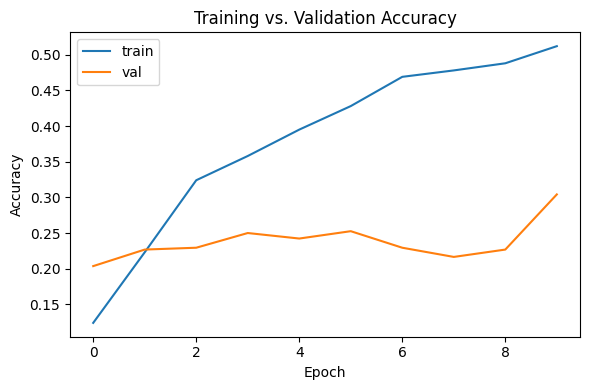

Final validation accuracy: 0.3041

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=Adam, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1247 - loss: 3.8478 - val_accuracy: 0.1469 - val_loss: 2.6647
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2584 - loss: 2.2641 - val_accuracy: 0.2552 - val_loss: 2.0732
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3502 - loss: 1.9043 - val_accuracy: 0.2088 - val_loss: 2.0875
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3558 - loss: 1.7922 - val_accuracy: 0.2294 - val_loss: 2.0945
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3957 - loss: 1.7168 - val_accuracy: 0.2268 - val_loss: 2.1264
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4152 - loss: 1.6477 - val_accuracy: 0.2294 - val_loss: 2.1101
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - ac

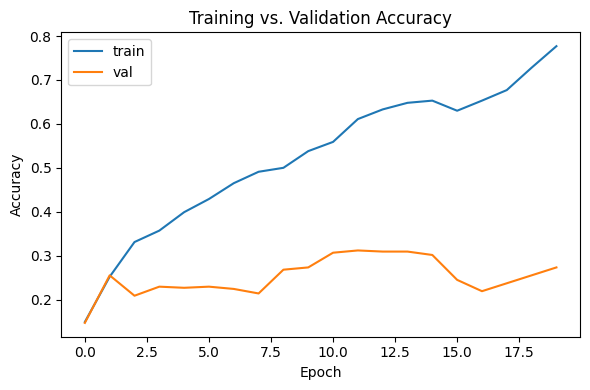

Final validation accuracy: 0.2732

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1160 - loss: 2.3724 - val_accuracy: 0.1366 - val_loss: 2.2343
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1976 - loss: 2.1889 - val_accuracy: 0.1546 - val_loss: 2.1954
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2108 - loss: 2.1347 - val_accuracy: 0.2165 - val_loss: 2.1133
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2666 - loss: 2.0289 - val_accuracy: 0.2448 - val_loss: 2.0640
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3020 - loss: 1.9749 - val_accuracy: 0.2552 - val_loss: 2.0564
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3143 - loss: 1.9430 - val_accuracy: 0.2629 - val_loss: 2.0494
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - a

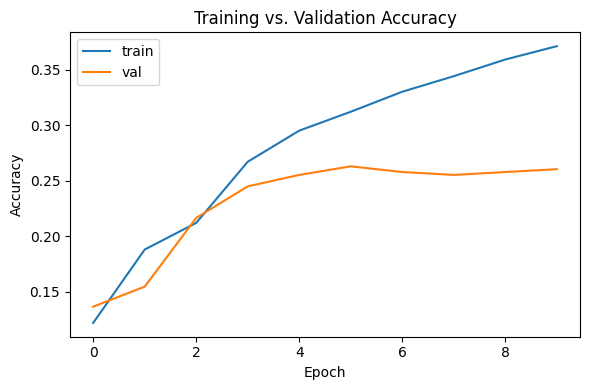

Final validation accuracy: 0.2603

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1060 - loss: 2.3914 - val_accuracy: 0.1521 - val_loss: 2.2217
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1895 - loss: 2.1973 - val_accuracy: 0.1881 - val_loss: 2.1899
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2030 - loss: 2.1136 - val_accuracy: 0.2216 - val_loss: 2.1125
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2753 - loss: 2.0207 - val_accuracy: 0.2165 - val_loss: 2.0780
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3141 - loss: 1.9727 - val_accuracy: 0.2010 - val_loss: 2.0692
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3282 - loss: 1.9382 - val_accuracy: 0.1881 - val_loss: 2.0587
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - a

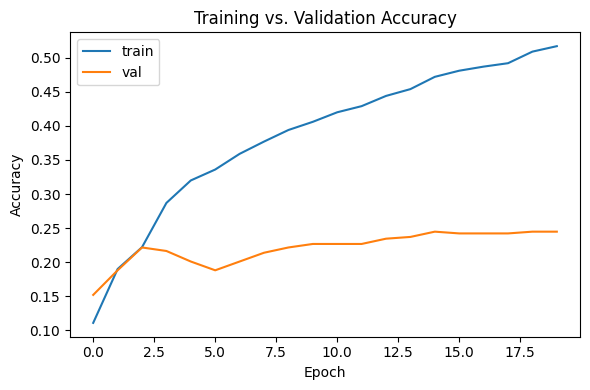

Final validation accuracy: 0.2448

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1346 - loss: 2.3470 - val_accuracy: 0.1804 - val_loss: 2.2373
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1216 - loss: 2.2784 - val_accuracy: 0.1985 - val_loss: 2.2002
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1466 - loss: 2.2350 - val_accuracy: 0.2010 - val_loss: 2.1703
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1758 - loss: 2.1985 - val_accuracy: 0.1985 - val_loss: 2.1458
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1967 - loss: 2.1675 - val_accuracy: 0.2010 - val_loss: 2.1255
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2047 - loss: 2.1406 - val_accuracy: 0.1985 - val_loss: 2.1084
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc

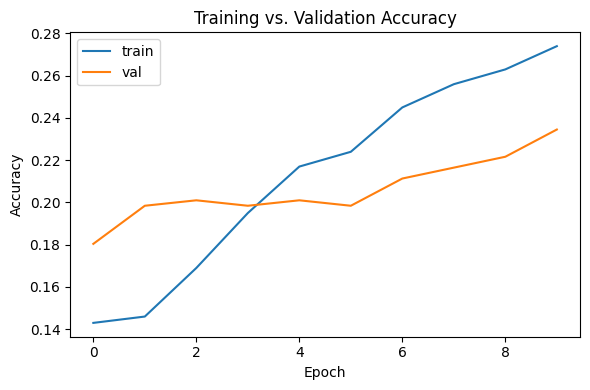

Final validation accuracy: 0.2345

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=SGD, learning_rate=0.001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1064 - loss: 2.3576 - val_accuracy: 0.1160 - val_loss: 2.2665
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1670 - loss: 2.2581 - val_accuracy: 0.1418 - val_loss: 2.2249
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2155 - loss: 2.2139 - val_accuracy: 0.1598 - val_loss: 2.1919
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2253 - loss: 2.1774 - val_accuracy: 0.1778 - val_loss: 2.1653
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2365 - loss: 2.1465 - val_accuracy: 0.1753 - val_loss: 2.1435
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2419 - loss: 2.1199 - val_accuracy: 0.1856 - val_loss: 2.1254
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc

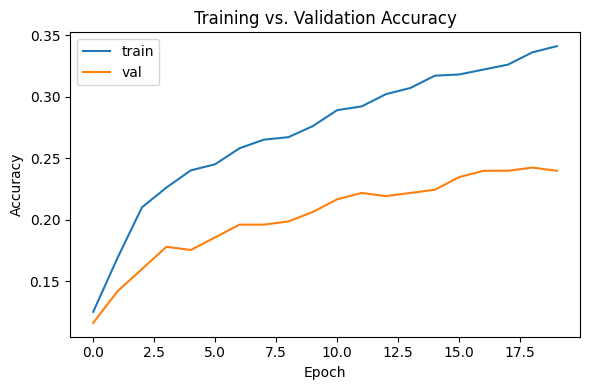

Final validation accuracy: 0.2397

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=10
Training on 1000 images, validating on 388 images ...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0897 - loss: 2.4158 - val_accuracy: 0.0799 - val_loss: 2.3792
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1023 - loss: 2.3676 - val_accuracy: 0.0851 - val_loss: 2.3448
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1035 - loss: 2.3414 - val_accuracy: 0.0954 - val_loss: 2.3242
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1087 - loss: 2.3255 - val_accuracy: 0.1186 - val_loss: 2.3109
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1169 - loss: 2.3148 - val_accuracy: 0.1160 - val_loss: 2.3013
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1231 - loss: 2.3067 - val_accuracy: 0.1237 - val_loss: 2.2938
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

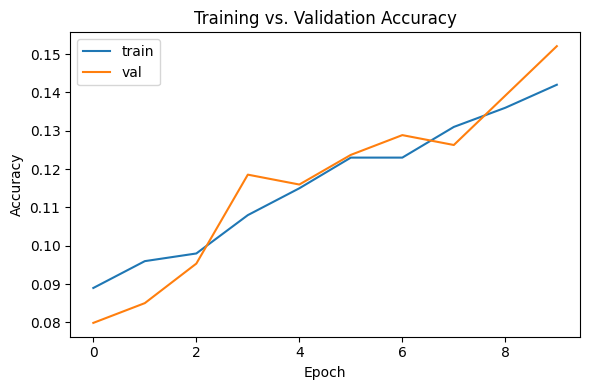

Final validation accuracy: 0.1521

Testing: hidden_layer_sizes=[], activation=tanh, optimizer=SGD, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1109 - loss: 2.4920 - val_accuracy: 0.1057 - val_loss: 2.4258
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1089 - loss: 2.4059 - val_accuracy: 0.1082 - val_loss: 2.3773
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1070 - loss: 2.3650 - val_accuracy: 0.1031 - val_loss: 2.3522
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1044 - loss: 2.3417 - val_accuracy: 0.1031 - val_loss: 2.3377
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1067 - loss: 2.3269 - val_accuracy: 0.1082 - val_loss: 2.3283
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1004 - loss: 2.3165 - val_accuracy: 0.1031 - val_loss: 2.3216
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

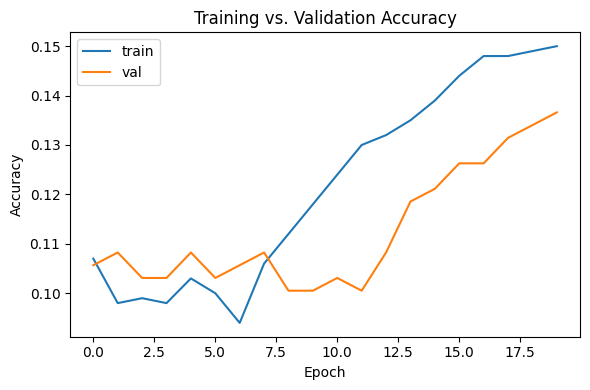

Final validation accuracy: 0.1366

Grid search results:


hidden_layer_sizes activation optimizer  learning_rate  num_epochs  \
0         [1024, 512]       relu      Adam         0.0010          10   
1         [1024, 512]       relu      Adam         0.0010          20   
2         [1024, 512]       relu      Adam         0.0001          10   
3         [1024, 512]       relu      Adam         0.0001          20   
4         [1024, 512]       relu       SGD         0.0010          10   
..                ...        ...       ...            ...         ...   
59                 []       tanh      Adam         0.0001          20   
60                 []       tanh       SGD         0.0010          10   
61                 []       tanh       SGD         0.0010          20   
62                 []       tanh       SGD         0.0001          10   
63                 []       tanh       SGD         0.0001          20   

    train_acc   val_acc  overfit_gap  
0       0.437  0.283505     0.153495  
1       0.672  0.229381     0.442619  
2       0.468  0.296392     0.171608  
3       0.667  0.260309     0.406691  
4       0.168  0.175258    -0.007258  
..        ...       ...          ...  
59      0.507  0.244845     0.262155  
60      0.281  0.234536     0.046464  
61      0.345  0.239691     0.105309  
62      0.146  0.152062    -0.006062  
63      0.153  0.136598     0.016402  

[64 rows x 8 columns]


Best configuration (not overfitted):
{'hidden_layer_sizes': [256], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.001, 'num_epochs': 20, 'train_acc': 0.257999986410141, 'val_acc': 0.25, 'overfit_gap': 0.007999986410140991}


In [ ]:
# import itertools
# import pandas as pd

# # Define parameter grid
# hidden_layer_sizes_list = [
#     [1024, 512],
#     [512, 256], 
#     [256],
#     []
# ]
# activations = ['relu', 'tanh']
# optimizers = ['Adam', 'SGD']
# learning_rates = [1e-3, 1e-4]
# num_epochs_list = [10, 20]

# results = []

# for hls, act, opt, lr, ne in itertools.product(
#         hidden_layer_sizes_list, activations, optimizers, learning_rates, num_epochs_list):

#     print(f"\nTesting: hidden_layer_sizes={hls}, activation={act}, optimizer={opt}, learning_rate={lr}, num_epochs={ne}")
    
#     try:
#         model = train_and_evaluate(
#             X_train_sub, y_train_sub_encoded,
#             X_val_sub,   y_val_sub_encoded,
#             hidden_layer_sizes=hls,
#             activation=act,
#             optimizer=opt,
#             learning_rate=lr,
#             num_epochs=ne
#         )
        
#         # Evaluate on train and val to check for overfitting
#         train_loss, train_acc = model.evaluate(X_train_sub, y_train_sub_encoded, verbose=0)
#         val_loss, val_acc = model.evaluate(X_val_sub, y_val_sub_encoded, verbose=0)
#         overfit_gap = train_acc - val_acc

#         results.append({
#             'hidden_layer_sizes': hls,
#             'activation': act,
#             'optimizer': opt,
#             'learning_rate': lr,
#             'num_epochs': ne,
#             'train_acc': train_acc,
#             'val_acc': val_acc,
#             'overfit_gap': overfit_gap,
#             'model': model  # Consider storing only weights: model.get_weights()
#         })
        
#     except Exception as e:
#         print(f"Error with configuration: {e}")
#         continue

# # Create DataFrame (excluding model objects)
# results_df = pd.DataFrame([
#     {k: v for k, v in r.items() if k != 'model'} for r in results
# ])

# print("\nGrid search results:")
# display(results_df)

# # Find best model (not overfitted)
# filtered = results_df[results_df['overfit_gap'] < 0.05]
# if not filtered.empty:
#     best_idx = filtered['val_acc'].idxmax()
# else:
#     best_idx = results_df['val_acc'].idxmax()

# best_row = results_df.loc[best_idx]
# best = results[best_idx]

# print("\nBest configuration (not overfitted):")
# print(best_row.to_dict())

# model = best['model']

In [ ]:
results_df.to_csv("results_df_unaugmented.csv", index=False)

In [ ]:
results_df

hidden_layer_sizes activation optimizer  learning_rate  num_epochs  \
0         [1024, 512]       relu      Adam         0.0010          10   
1         [1024, 512]       relu      Adam         0.0010          20   
2         [1024, 512]       relu      Adam         0.0001          10   
3         [1024, 512]       relu      Adam         0.0001          20   
4         [1024, 512]       relu       SGD         0.0010          10   
..                ...        ...       ...            ...         ...   
59                 []       tanh      Adam         0.0001          20   
60                 []       tanh       SGD         0.0010          10   
61                 []       tanh       SGD         0.0010          20   
62                 []       tanh       SGD         0.0001          10   
63                 []       tanh       SGD         0.0001          20   

    train_acc   val_acc  overfit_gap  
0       0.437  0.283505     0.153495  
1       0.672  0.229381     0.442619  
2       0.468  0.296392     0.171608  
3       0.667  0.260309     0.406691  
4       0.168  0.175258    -0.007258  
..        ...       ...          ...  
59      0.507  0.244845     0.262155  
60      0.281  0.234536     0.046464  
61      0.345  0.239691     0.105309  
62      0.146  0.152062    -0.006062  
63      0.153  0.136598     0.016402  

[64 rows x 8 columns]

Takeaways:
1. Dense nets overfit quickly - there are huge training gaps as there are only 1000 training images. 
2. Lower learning rates help with generalization
3. ReLu and tanh cap out at about 30% when not fitting

Compared the tbaseline (which is about 28% accuracy) the below is the best on this small subset:

hidden_layer_sizes : [1024, 512]
activation         : relu
optimizer          : Adam
learning_rate      : 1e-4
num_epochs         : 10
train_acc          : 0.468
val_acc            : 0.296
overfit_gap        : 0.172

So these extra hidden layers don't contribute very much - mostly overfitting.


# Stage 2.5: Fully connected neural network (Full Data w/ Augmentation)

In [10]:
# Re-encode just the subset data to get consecutive labels
from sklearn.preprocessing import LabelEncoder

# Create a new encoder just for the subset
subset_encoder = LabelEncoder()

# Fit and transform just the subset data
y_train_sub_encoded = subset_encoder.fit_transform(y_train_sub)
y_val_sub_encoded = subset_encoder.transform(y_val_sub)

# Check the results
print("Unique values in y_train_sub_encoded:", np.unique(y_train_sub_encoded))
print("Number of unique classes:", len(np.unique(y_train_sub_encoded)))
print("Min value:", np.min(y_train_sub_encoded))
print("Max value:", np.max(y_train_sub_encoded))
# Now your labels should be 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

Unique values in y_train_sub_encoded: [0 1 2 3 4 5 6 7 8 9]
Number of unique classes: 10
Min value: 0
Max value: 9


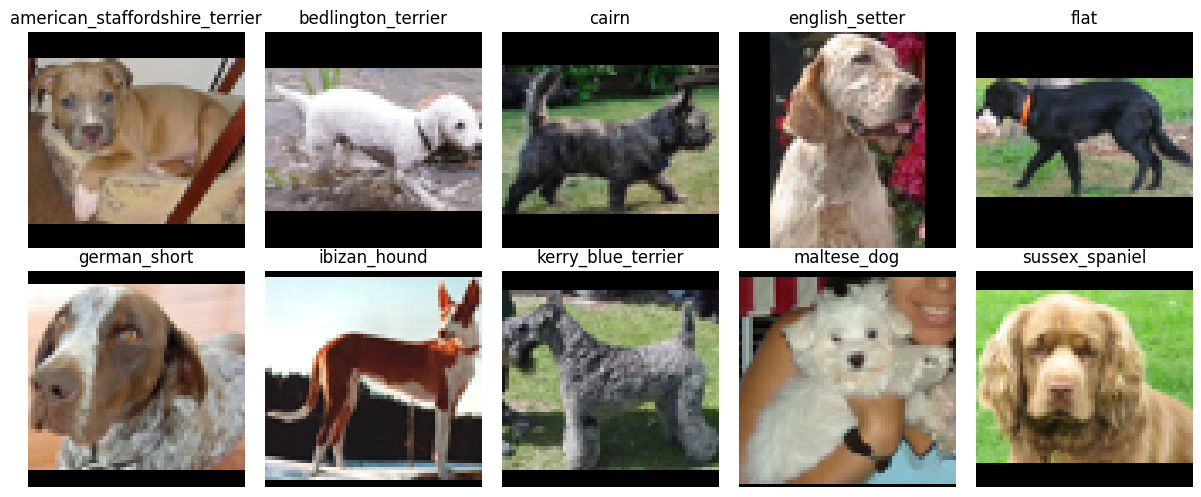

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
# Show 1 dog for each of the 10 unique breeds in y_train_sub, arranged 5 in 2 rows
label_to_idx = {}
for idx, label in enumerate(y_train_sub):
    if label not in label_to_idx:
        label_to_idx[label] = idx
    if len(label_to_idx) == 10:
        break

label_list = sorted(label_to_idx.keys())
for j, label in enumerate(label_list):
    plt.subplot(2, 5, j+1)
    plt.imshow(X_train_sub[label_to_idx[label]])
    plt.axis('off')
    plt.title(f"{label}")
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd

# Count how many dogs per breed in y_train_sub
breed_counts = pd.Series(y_train_sub).value_counts().sort_index()
print("Number of dogs per breed in y_train_sub:")
print(breed_counts)

Number of dogs per breed in y_train_sub:
american_staffordshire_terrier    100
bedlington_terrier                100
cairn                             100
english_setter                    100
flat                              100
german_short                      100
ibizan_hound                      100
kerry_blue_terrier                100
maltese_dog                       100
sussex_spaniel                    100
Name: count, dtype: int64


In [ ]:
def train_and_evaluate(X_train, y_train,
                       X_val,   y_val,
                       hidden_layer_sizes=None,
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=1e-3,
                       metric='accuracy',
                       num_epochs=10,
                       batch_size=64,
                       data_augmentation=None):
    """
    Train a dense network (or logistic-regression baseline) on Stanford Dogs data.
    """
    hidden_layer_sizes = hidden_layer_sizes or []


    n_classes = len(np.unique(y_train))
    model = build_model(n_classes=n_classes,
                        hidden_layer_sizes=hidden_layer_sizes,
                        activation=activation,
                        optimizer=optimizer,
                        learning_rate=learning_rate,
                        metric=metric,
                        data_augmentation=data_augmentation)

    print("Training on %d images, validating on %d images ..."
          % (len(X_train), len(X_val)))

    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1
    )

    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Final validation accuracy: {val_acc:.4f}")

    return model

Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.1117 - loss: 2.2975 - val_accuracy: 0.1933 - val_loss: 2.1821
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.1704 - loss: 2.2103 - val_accuracy: 0.2474 - val_loss: 2.1147
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.2023 - loss: 2.1419 - val_accuracy: 0.2861 - val_loss: 2.0628
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.2215 - loss: 2.0776 - val_accuracy: 0.2990 - val_loss: 2.0249
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.2627 - loss: 2.0360 - val_accuracy: 0.2964 - val_loss: 1.9950
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.2793 - loss: 2.0078 - val_accuracy: 0.3015 - val_loss: 1.9628
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.2960 - loss: 1.9627 - val_accuracy: 0.2887 - val_loss: 1.9478
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/ste

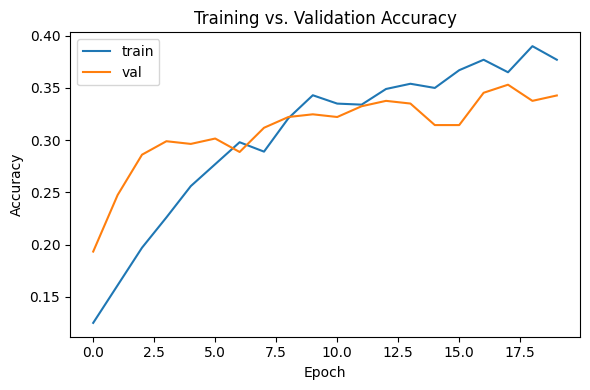

Final validation accuracy: 0.3428


In [37]:
model = train_and_evaluate(
    X_train_sub, y_train_sub_encoded,
    X_val_sub,   y_val_sub_encoded,
    hidden_layer_sizes=[1024, 512],
    activation='relu',
    optimizer='Adam',
    learning_rate=1e-4,
    num_epochs=20,
    data_augmentation=data_augmentation
)


Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.0888 - loss: 2.2872 - val_accuracy: 0.2191 - val_loss: 2.1899
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.1522 - loss: 2.2118 - val_accuracy: 0.2397 - val_loss: 2.1059
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.1726 - loss: 2.1591 - val_accuracy: 0.2784 - val_loss: 2.0845
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.2131 - loss: 2.0997 - val_accuracy: 0.2861 - val_loss: 2.0445
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.2638 - loss: 2.0593 - val_accuracy: 0.2964 - val_loss: 2.0070
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2653 - loss: 2.0257 - val_accuracy: 0.3041 - val_loss: 1.9740
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.2723 - loss: 1.9878 - val_accuracy: 0.2938 - val_loss: 1.9503
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/st

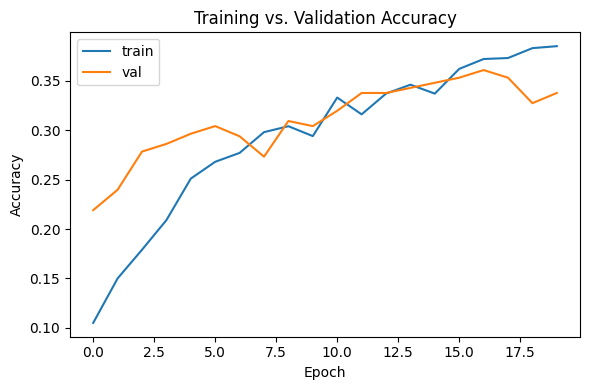

Final validation accuracy: 0.3376


In [36]:
model = train_and_evaluate(
    X_train_sub, y_train_sub_encoded,
    X_val_sub,   y_val_sub_encoded,
    hidden_layer_sizes=[1024, 512, 256],
    activation='relu',
    optimizer='Adam',
    learning_rate=1e-4,
    num_epochs=20,
    data_augmentation=data_augmentation
)


Testing: hidden_layer_sizes=[1024, 512, 256], activation=relu, optimizer=Adam, learning_rate=0.001, num_epochs=20

Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.1024 - loss: 2.3665 - val_accuracy: 0.1521 - val_loss: 2.1742
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.1293 - loss: 2.2372 - val_accuracy: 0.2655 - val_loss: 2.0928
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.1842 - loss: 2.1314 - val_accuracy: 0.2294 - val_loss: 2.0597
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2200 - loss: 2.0756 - val_accuracy: 0.2062 - val_loss: 2.0461
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.2587 - loss: 1.9937 - val_accuracy: 0.2526 - val_loss: 1.9812
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.2992 - loss: 1.9405 - val_accuracy: 0.2680 - val_loss: 1.9256
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy

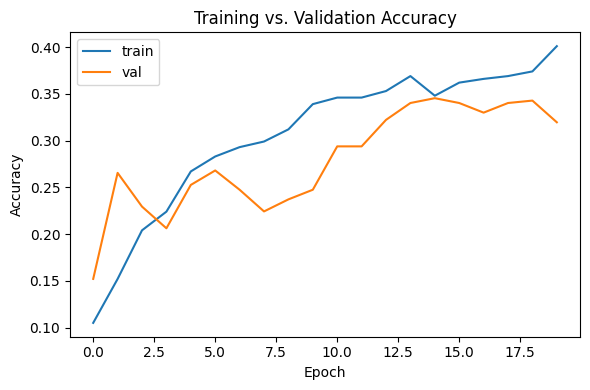

Final validation accuracy: 0.3196

Testing: hidden_layer_sizes=[1024, 512, 256], activation=relu, optimizer=Adam, learning_rate=0.0001, num_epochs=20
Training on 1000 images, validating on 388 images ...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.1125 - loss: 2.2894 - val_accuracy: 0.1933 - val_loss: 2.2036
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.1830 - loss: 2.2214 - val_accuracy: 0.2577 - val_loss: 2.1295
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.1825 - loss: 2.1641 - val_accuracy: 0.2655 - val_loss: 2.0776
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.2353 - loss: 2.1155 - val_accuracy: 0.2706 - val_loss: 2.0455
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.2542 - loss: 2.0617 - val_accuracy: 0.2680 - val_loss: 2.0211
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.2502 - loss: 2.0320 - val_accuracy: 0.2784 - val_loss: 1.9785
Epoch 7/20
 1/16 ━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
# # Define parameter grid
# hidden_layer_sizes_list = [
#     [1024, 512, 256],
#     [1024, 512],
#     [256],
# ]
# activations = ['relu', 'tanh']
# optimizers = ['Adam']
# learning_rates = [1e-3, 1e-4]
# num_epochs_list = [20]

# results = []

# for hls, act, opt, lr, ne in itertools.product(
#         hidden_layer_sizes_list, activations, optimizers, learning_rates, num_epochs_list):

#     print(f"\nTesting: hidden_layer_sizes={hls}, activation={act}, optimizer={opt}, learning_rate={lr}, num_epochs={ne}")
    
#     try:
#         model = train_and_evaluate(
#             X_train_sub, y_train_sub_encoded,
#             X_val_sub,   y_val_sub_encoded,
#             hidden_layer_sizes=hls,
#             activation=act,
#             optimizer=opt,
#             learning_rate=lr,
#             num_epochs=ne,
#             data_augmentation=data_augmentation
#         )
        
#         # Evaluate on train and val to check for overfitting
#         train_loss, train_acc = model.evaluate(X_train_sub, y_train_sub_encoded, verbose=0)
#         val_loss, val_acc = model.evaluate(X_val_sub, y_val_sub_encoded, verbose=0)
#         overfit_gap = train_acc - val_acc

#         results.append({
#             'hidden_layer_sizes': hls,
#             'activation': act,
#             'optimizer': opt,
#             'learning_rate': lr,
#             'num_epochs': ne,
#             'train_acc': train_acc,
#             'val_acc': val_acc,
#             'overfit_gap': overfit_gap,
#             'model': model  # Consider storing only weights: model.get_weights()
#         })
        
#     except Exception as e:
#         print(f"Error with configuration: {e}")
#         continue

# # Create DataFrame (excluding model objects)
# results_df = pd.DataFrame([
#     {k: v for k, v in r.items() if k != 'model'} for r in results
# ])

# print("\nGrid search results:")
# display(results_df)

# # Find best model (not overfitted)
# filtered = results_df[results_df['overfit_gap'] < 0.05]
# if not filtered.empty:
#     best_idx = filtered['val_acc'].idxmax()
# else:
#     best_idx = results_df['val_acc'].idxmax()

# best_row = results_df.loc[best_idx]
# best = results[best_idx]

# print("\nBest configuration (not overfitted):")
# print(best_row.to_dict())

# model = best['model']


>>> Testing: hls=[1024, 512, 256] | act=relu | opt=Adam | lr=0.001 | epochs=20
Training on 1000 images | validating on 388 images
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.1256 - loss: 2.3896 - val_accuracy: 0.2320 - val_loss: 2.1652
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.1618 - loss: 2.2402 - val_accuracy: 0.2474 - val_loss: 2.0871
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.2211 - loss: 2.1357 - val_accuracy: 0.2474 - val_loss: 2.0246
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.2424 - loss: 2.0476 - val_accuracy: 0.2139 - val_loss: 2.0370
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.2499 - loss: 2.0154 - val_accuracy: 0.2552 - val_loss: 1.9782
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2882 - loss: 1.9402 - val_accuracy: 0.2165 - val_loss: 1.9538
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.3176 - loss: 1.9003 - val_accuracy:

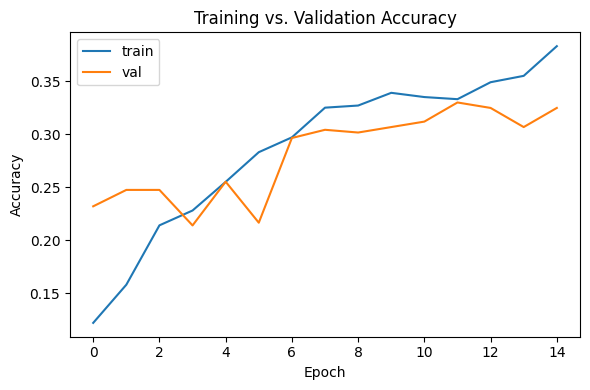

Final validation accuracy: 0.3299

>>> Testing: hls=[1024, 512, 256] | act=relu | opt=Adam | lr=0.0001 | epochs=20
Training on 1000 images | validating on 388 images
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.0943 - loss: 2.2973 - val_accuracy: 0.2320 - val_loss: 2.2243
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.1652 - loss: 2.2382 - val_accuracy: 0.2577 - val_loss: 2.1397
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.1942 - loss: 2.1581 - val_accuracy: 0.2629 - val_loss: 2.0856
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.1988 - loss: 2.1189 - val_accuracy: 0.2758 - val_loss: 2.0508
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.2534 - loss: 2.0584 - val_accuracy: 0.2835 - val_loss: 2.0188
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.2557 - loss: 2.0361 - val_accuracy: 0.3041 - val_loss: 1.9845
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.

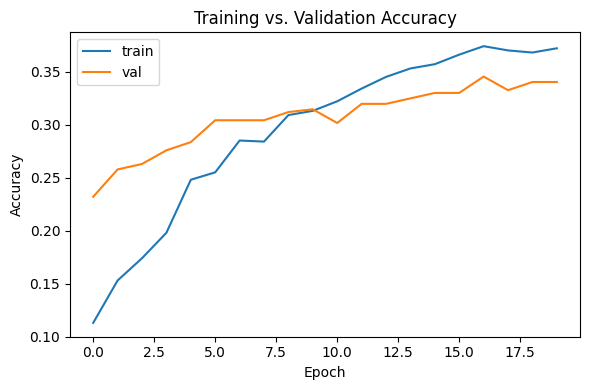

Final validation accuracy: 0.3325

>>> Testing: hls=[1024, 512, 256] | act=tanh | opt=Adam | lr=0.001 | epochs=20
Training on 1000 images | validating on 388 images
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.0900 - loss: 2.3151 - val_accuracy: 0.0928 - val_loss: 2.2531
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.1452 - loss: 2.2273 - val_accuracy: 0.1160 - val_loss: 2.2707
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.1364 - loss: 2.2216 - val_accuracy: 0.1649 - val_loss: 2.1867
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.1637 - loss: 2.1738 - val_accuracy: 0.1186 - val_loss: 2.1992
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.1643 - loss: 2.1760 - val_accuracy: 0.1134 - val_loss: 2.2556
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.1549 - loss: 2.1708 - val_accuracy: 0.1314 - val_loss: 2.1495
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.1

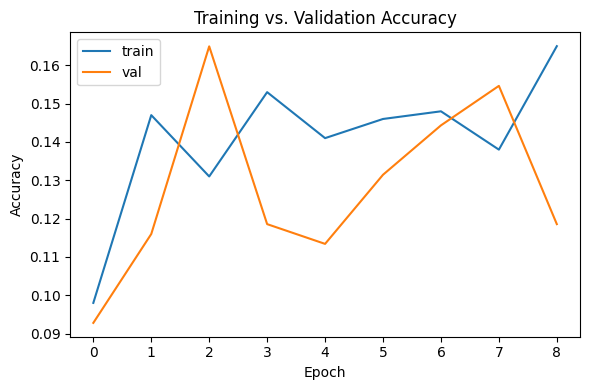

Final validation accuracy: 0.1314

>>> Testing: hls=[1024, 512, 256] | act=tanh | opt=Adam | lr=0.0001 | epochs=20
Training on 1000 images | validating on 388 images
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.0979 - loss: 2.3135 - val_accuracy: 0.1804 - val_loss: 2.2304
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.1893 - loss: 2.2244 - val_accuracy: 0.2629 - val_loss: 2.1597
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.2387 - loss: 2.1475 - val_accuracy: 0.2861 - val_loss: 2.1008
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.2512 - loss: 2.0915 - val_accuracy: 0.2835 - val_loss: 2.0495
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.2686 - loss: 2.0416 - val_accuracy: 0.2938 - val_loss: 2.0170
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.2987 - loss: 1.9985 - val_accuracy: 0.2758 - val_loss: 1.9896
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.

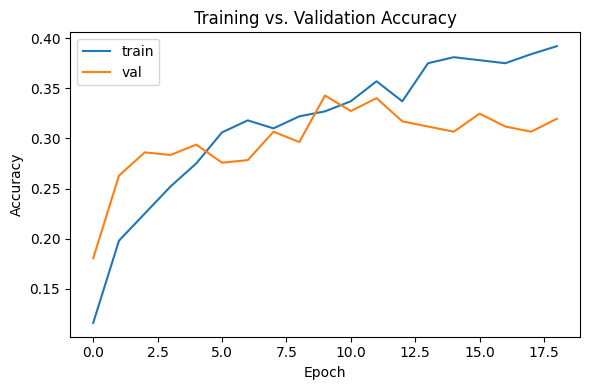

Final validation accuracy: 0.3247

>>> Testing: hls=[1024, 512] | act=relu | opt=Adam | lr=0.001 | epochs=20
Training on 1000 images | validating on 388 images
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.1070 - loss: 2.6321 - val_accuracy: 0.1753 - val_loss: 2.2742
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.1674 - loss: 2.2678 - val_accuracy: 0.2500 - val_loss: 2.1075
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.2274 - loss: 2.1185 - val_accuracy: 0.2809 - val_loss: 2.0326
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.2403 - loss: 2.0218 - val_accuracy: 0.2603 - val_loss: 2.0270
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2643 - loss: 1.9586 - val_accuracy: 0.2139 - val_loss: 2.0560
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.2956 - loss: 1.9332 - val_accuracy: 0.2397 - val_loss: 1.9560
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.2822 -

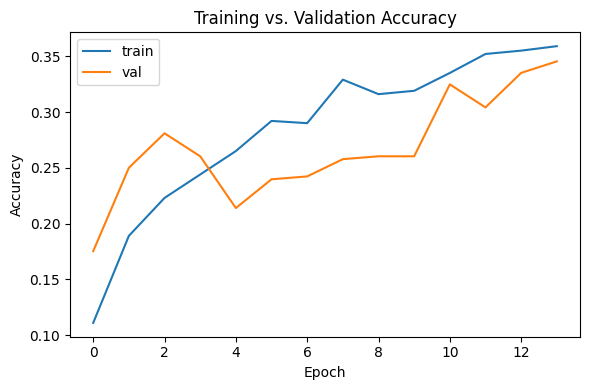

Final validation accuracy: 0.3247

>>> Testing: hls=[1024, 512] | act=relu | opt=Adam | lr=0.0001 | epochs=20
Training on 1000 images | validating on 388 images
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.1053 - loss: 2.2926 - val_accuracy: 0.2268 - val_loss: 2.1815
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.1589 - loss: 2.2041 - val_accuracy: 0.2603 - val_loss: 2.0896
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.1788 - loss: 2.1434 - val_accuracy: 0.2629 - val_loss: 2.0547
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.2136 - loss: 2.0844 - val_accuracy: 0.2732 - val_loss: 2.0175
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.2380 - loss: 2.0375 - val_accuracy: 0.3170 - val_loss: 1.9875
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.2765 - loss: 1.9977 - val_accuracy: 0.3041 - val_loss: 1.9589
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.2642 

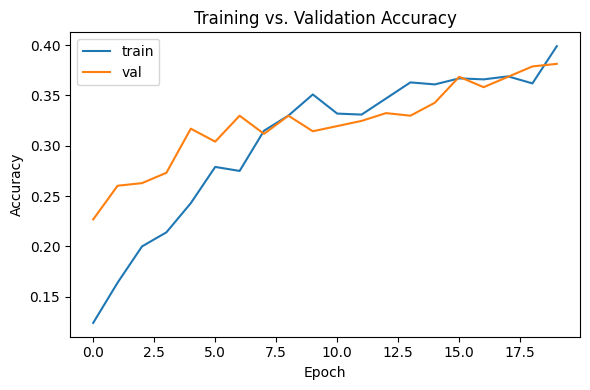

Final validation accuracy: 0.3789

>>> Testing: hls=[1024, 512] | act=tanh | opt=Adam | lr=0.001 | epochs=20
Training on 1000 images | validating on 388 images
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.0944 - loss: 2.3862 - val_accuracy: 0.0954 - val_loss: 2.2715
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.1559 - loss: 2.2587 - val_accuracy: 0.1057 - val_loss: 2.1897
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.1591 - loss: 2.2046 - val_accuracy: 0.0979 - val_loss: 2.2264
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.1426 - loss: 2.2101 - val_accuracy: 0.0979 - val_loss: 2.2486
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.1350 - loss: 2.2112 - val_accuracy: 0.1134 - val_loss: 2.1985


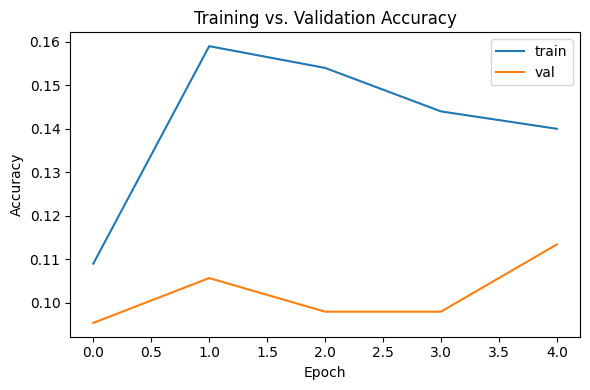

Final validation accuracy: 0.1057

>>> Testing: hls=[1024, 512] | act=tanh | opt=Adam | lr=0.0001 | epochs=20
Training on 1000 images | validating on 388 images
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.1253 - loss: 2.3114 - val_accuracy: 0.1314 - val_loss: 2.2011
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.1755 - loss: 2.1735 - val_accuracy: 0.2088 - val_loss: 2.1133
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.2102 - loss: 2.0963 - val_accuracy: 0.2784 - val_loss: 2.0417
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.2369 - loss: 2.0497 - val_accuracy: 0.3144 - val_loss: 1.9859
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.2581 - loss: 2.0095 - val_accuracy: 0.3144 - val_loss: 1.9563
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.2740 - loss: 1.9651 - val_accuracy: 0.3196 - val_loss: 1.9224
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.2988 

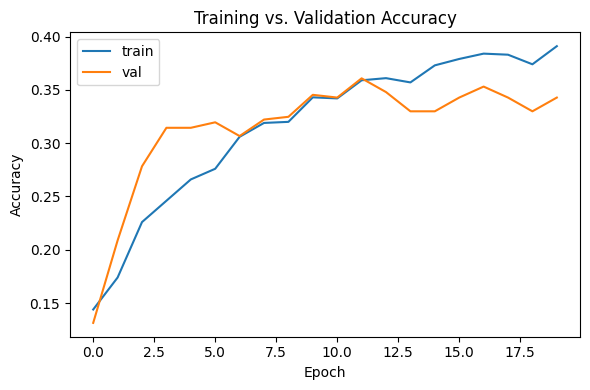

Final validation accuracy: 0.3531

>>> Testing: hls=[256] | act=relu | opt=Adam | lr=0.001 | epochs=20
Training on 1000 images | validating on 388 images
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1250 - loss: 2.3852 - val_accuracy: 0.1521 - val_loss: 2.1100
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2089 - loss: 2.1295 - val_accuracy: 0.2577 - val_loss: 2.0665
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2230 - loss: 2.1035 - val_accuracy: 0.2938 - val_loss: 1.9877
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2686 - loss: 2.0121 - val_accuracy: 0.2809 - val_loss: 1.9810
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2927 - loss: 1.9648 - val_accuracy: 0.2680 - val_loss: 1.9469
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2949 - loss: 1.9399 - val_accuracy: 0.2809 - val_loss: 1.9073
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3152 - loss: 1.8844

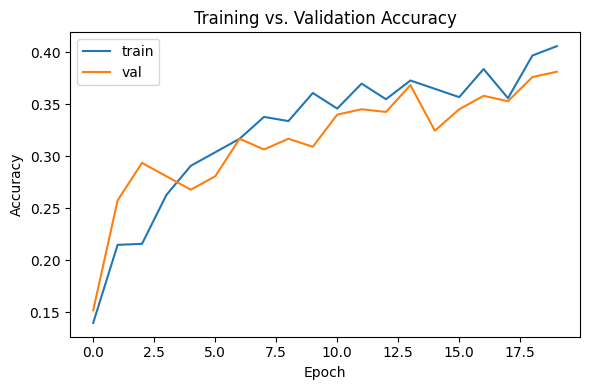

Final validation accuracy: 0.3763

>>> Testing: hls=[256] | act=relu | opt=Adam | lr=0.0001 | epochs=20
Training on 1000 images | validating on 388 images
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.0904 - loss: 2.2976 - val_accuracy: 0.2345 - val_loss: 2.2151
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1688 - loss: 2.2337 - val_accuracy: 0.2397 - val_loss: 2.1549
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2038 - loss: 2.1710 - val_accuracy: 0.2423 - val_loss: 2.1182
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2213 - loss: 2.1370 - val_accuracy: 0.2577 - val_loss: 2.0914
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2402 - loss: 2.0965 - val_accuracy: 0.2603 - val_loss: 2.0679
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2457 - loss: 2.0656 - val_accuracy: 0.2784 - val_loss: 2.0430
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2511 - loss: 2.049

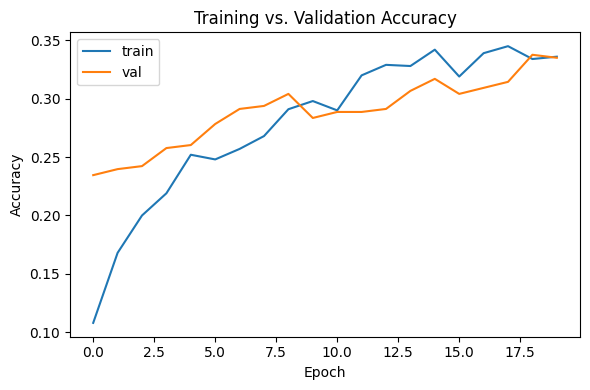

Final validation accuracy: 0.3351

>>> Testing: hls=[256] | act=tanh | opt=Adam | lr=0.001 | epochs=20
Training on 1000 images | validating on 388 images
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.1286 - loss: 2.3739 - val_accuracy: 0.1160 - val_loss: 2.2953
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1187 - loss: 2.2677 - val_accuracy: 0.1778 - val_loss: 2.2061
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1665 - loss: 2.2073 - val_accuracy: 0.1804 - val_loss: 2.1782
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1790 - loss: 2.1861 - val_accuracy: 0.1649 - val_loss: 2.1516
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1863 - loss: 2.1608 - val_accuracy: 0.1830 - val_loss: 2.1486
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1992 - loss: 2.1388 - val_accuracy: 0.2165 - val_loss: 2.1328
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2212 - loss: 2.1229

Final validation accuracy: 0.2629

>>> Testing: hls=[256] | act=tanh | opt=Adam | lr=0.0001 | epochs=20
Training on 1000 images | validating on 388 images
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0966 - loss: 2.3070 - val_accuracy: 0.1314 - val_loss: 2.2317
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1737 - loss: 2.2290 - val_accuracy: 0.2423 - val_loss: 2.1654
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2354 - loss: 2.1505 - val_accuracy: 0.2577 - val_loss: 2.1324
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2408 - loss: 2.1232 - val_accuracy: 0.2655 - val_loss: 2.1002
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2796 - loss: 2.0760 - val_accuracy: 0.2758 - val_loss: 2.0780
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2839 - loss: 2.0602 - val_accuracy: 0.2758 - val_loss: 2.0615
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2982 - loss: 2.032

Final validation accuracy: 0.3273

================  Grid-Search Results  ================


hidden_layer_sizes activation optimizer  learning_rate  num_epochs  \
0    [1024, 512, 256]       relu      Adam         0.0010          20   
1    [1024, 512, 256]       relu      Adam         0.0001          20   
2    [1024, 512, 256]       tanh      Adam         0.0010          20   
3    [1024, 512, 256]       tanh      Adam         0.0001          20   
4         [1024, 512]       relu      Adam         0.0010          20   
5         [1024, 512]       relu      Adam         0.0001          20   
6         [1024, 512]       tanh      Adam         0.0010          20   
7         [1024, 512]       tanh      Adam         0.0001          20   
8               [256]       relu      Adam         0.0010          20   
9               [256]       relu      Adam         0.0001          20   
10              [256]       tanh      Adam         0.0010          20   
11              [256]       tanh      Adam         0.0001          20   

    train_acc   val_acc  overfit_gap  
0       0.370  0.329897     0.040103  
1       0.379  0.332474     0.046526  
2       0.160  0.131443     0.028557  
3       0.388  0.324742     0.063258  
4       0.376  0.324742     0.051258  
5       0.415  0.378866     0.036134  
6       0.143  0.105670     0.037330  
7       0.390  0.353093     0.036907  
8       0.417  0.376289     0.040711  
9       0.370  0.335052     0.034948  
10      0.295  0.262887     0.032113  
11      0.378  0.327320     0.050680


================  BEST CONFIGURATION  =================
{'hidden_layer_sizes': [1024, 512], 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.0001, 'num_epochs': 20, 'train_acc': 0.41499999165534973, 'val_acc': 0.3788659870624542, 'overfit_gap': 0.03613400459289551}


In [18]:
# Hyperparameter search w/ Early Stopping
# Define the search space
hidden_layer_sizes_list = [
    [1024, 512, 256],
    [1024, 512],
    [256],
]
activations      = ['relu', 'tanh']
optimizers       = ['Adam']
learning_rates   = [1e-3, 1e-4]
num_epochs_list  = [20]

results = []

# Shared EarlyStopping callback (reuse across trials to save memory)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True)

for hls, act, opt, lr, ne in itertools.product(
        hidden_layer_sizes_list, activations, optimizers, learning_rates, num_epochs_list):

    print(f"\n>>> Testing: hls={hls} | act={act} | opt={opt} | lr={lr} | epochs={ne}")

    try:
        model = train_and_evaluate(
            X_train_sub, y_train_sub_encoded,
            X_val_sub,   y_val_sub_encoded,
            hidden_layer_sizes=hls,
            activation=act,
            optimizer=opt,
            learning_rate=lr,
            num_epochs=ne,
            data_augmentation=data_augmentation,
            callbacks=[early_stop]        # pass ES here
        )

        # Record metrics
        train_loss, train_acc = model.evaluate(X_train_sub, y_train_sub_encoded, verbose=0)
        val_loss,   val_acc   = model.evaluate(X_val_sub,   y_val_sub_encoded,   verbose=0)

        results.append({
            'hidden_layer_sizes': hls,
            'activation': act,
            'optimizer': opt,
            'learning_rate': lr,
            'num_epochs': ne,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'overfit_gap': train_acc - val_acc,
            'model': model       # keep model if you need it
        })

    except Exception as e:
        print(f"⚠️  Skipped due to error: {e}")
        continue

# Convert to DataFrame for easy inspection
results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'model'} for r in results
])

print("\n================  Grid-Search Results  ================")
display(results_df)

# Pick best model (prioritize low overfitting)
filtered = results_df[results_df['overfit_gap'] < 0.05]
best_idx = filtered['val_acc'].idxmax() if not filtered.empty else results_df['val_acc'].idxmax()

best_row  = results_df.loc[best_idx]
best_model = results[best_idx]['model']

print("\n================  BEST CONFIGURATION  =================")
print(best_row.to_dict())

In [19]:
results_df.to_csv('results_df_augmented_earlystopping.csv', index=False)

In [ ]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

# --------------------------------------------------------------
# 1.  Predict labels for the validation split
# --------------------------------------------------------------
y_val_pred = np.argmax(
    model.predict(X_val_sub, batch_size=64, verbose=0),
    axis=1
)

# --------------------------------------------------------------
# 2.  F1 scores
#    • macro  – unweighted mean of class-wise F1
#    • weighted – class-wise F1 weighted by support
# --------------------------------------------------------------
f1_macro    = f1_score(y_val_sub_encoded, y_val_pred, average='macro')
f1_weighted = f1_score(y_val_sub_encoded, y_val_pred, average='weighted')

print(f"Macro-avg F1:    {f1_macro:.4f}")
print(f"Weighted F1:     {f1_weighted:.4f}")

# Optional: full class-wise report
print("\n--- Classification Report (excerpt) ---")
print(classification_report(
    y_val_sub_encoded,
    y_val_pred,
    digits=3
)[:1000])   # truncate if 100 classes clutters the console

#Precision: “Of all images I predicted as breed X, how many were actually breed X?”

#Recall: “Of all true breed X images, how many did I catch?”

Macro-avg F1:    0.2784
Weighted F1:     0.2989

--- Classification Report (excerpt) ---
              precision    recall  f1-score   support

           0      0.071     0.031     0.043        32
           1      0.314     0.268     0.289        41
           2      0.222     0.042     0.070        48
           3      0.154     0.133     0.143        30
           4      0.293     0.462     0.358        26
           5      0.095     0.154     0.118        26
           6      0.343     0.273     0.304        44
           7      0.333     0.400     0.364        40
           8      0.512     0.566     0.537        76
           9      0.407     0.880     0.557        25

    accuracy                          0.327       388
   macro avg      0.275     0.321     0.278       388
weighted avg      0.304     0.327     0.299       388



In [26]:
import numpy as np

# Count occurrences of each class in y_val_sub
unique, counts = np.unique(y_val_sub, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class counts in y_val_sub:")
for cls, cnt in class_counts.items():
    print(f"Class {cls}: {cnt}")

Class counts in y_val_sub:
Class american_staffordshire_terrier: 32
Class bedlington_terrier: 41
Class cairn: 48
Class english_setter: 30
Class flat: 26
Class german_short: 26
Class ibizan_hound: 44
Class kerry_blue_terrier: 40
Class maltese_dog: 76
Class sussex_spaniel: 25


# Stage 3: Fully connected neural network (Full Data)

In [8]:
# Convert string labels to integers for all classes
from sklearn.preprocessing import LabelEncoder

# Fit the encoder on all training labels (including all classes)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Number of unique classes: {len(label_encoder.classes_)}")

Number of unique classes: 120


## Early Stopping Version


>>> hls=[1024, 512, 256] | act=relu | opt=Adam | lr=0.001 | epochs=20

Training on 12000 images | validating on 4290 images
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.0112 - loss: 4.7953 - val_accuracy: 0.0159 - val_loss: 4.6593
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.0162 - loss: 4.6387 - val_accuracy: 0.0256 - val_loss: 4.5251
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.0271 - loss: 4.4906 - val_accuracy: 0.0427 - val_loss: 4.3923
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.0383 - loss: 4.3721 - val_accuracy: 0.0413 - val_loss: 4.3842
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.0420 - loss: 4.3387 - val_accuracy: 0.0429 - val_loss: 4.3747
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.0472 - loss: 4.2902 - val_accuracy: 0.0429 - val_loss: 4.3581
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.0476 - loss: 4.2589 

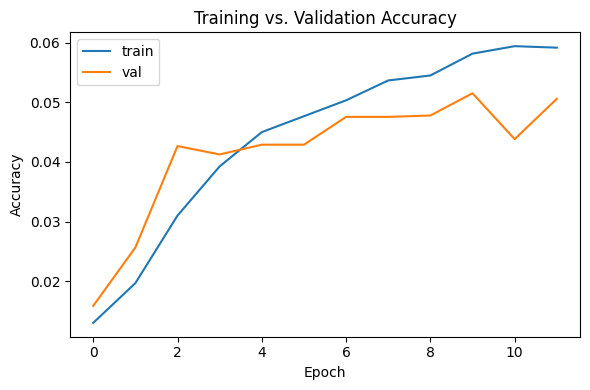

Final validation accuracy: 0.0478

>>> hls=[1024, 512, 256] | act=relu | opt=Adam | lr=0.0001 | epochs=20
Training on 12000 images | validating on 4290 images
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.0095 - loss: 4.7804 - val_accuracy: 0.0159 - val_loss: 4.6816
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.0212 - loss: 4.6545 - val_accuracy: 0.0282 - val_loss: 4.5130
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.0349 - loss: 4.4693 - val_accuracy: 0.0382 - val_loss: 4.4036
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.0402 - loss: 4.3745 - val_accuracy: 0.0429 - val_loss: 4.3746
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.0466 - loss: 4.3239 - val_accuracy: 0.0420 - val_loss: 4.3458
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.0487 - loss: 4.2897 - val_accuracy: 0.0527 - val_loss: 4.3102
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step 

Final validation accuracy: 0.0639

>>> hls=[1024, 512, 256] | act=tanh | opt=Adam | lr=0.001 | epochs=20
Training on 12000 images | validating on 4290 images
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.0082 - loss: 4.8489 - val_accuracy: 0.0065 - val_loss: 4.8483
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.0065 - loss: 4.8753 - val_accuracy: 0.0058 - val_loss: 4.8510
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.0067 - loss: 4.8770 - val_accuracy: 0.0058 - val_loss: 4.8561
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.0066 - loss: 4.8784 - val_accuracy: 0.0058 - val_loss: 4.8544


Final validation accuracy: 0.0065

>>> hls=[1024, 512, 256] | act=tanh | opt=Adam | lr=0.0001 | epochs=20
Training on 12000 images | validating on 4290 images
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.0116 - loss: 4.7828 - val_accuracy: 0.0233 - val_loss: 4.6845
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.0235 - loss: 4.6334 - val_accuracy: 0.0366 - val_loss: 4.5147
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.0362 - loss: 4.4668 - val_accuracy: 0.0361 - val_loss: 4.4215
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.0426 - loss: 4.3720 - val_accuracy: 0.0448 - val_loss: 4.3544
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.0478 - loss: 4.3214 - val_accuracy: 0.0452 - val_loss: 4.3260
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.0502 - loss: 4.2895 - val_accuracy: 0.0436 - val_loss: 4.3201
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step 

Final validation accuracy: 0.0580

>>> hls=[1024, 512] | act=relu | opt=Adam | lr=0.001 | epochs=20
Training on 12000 images | validating on 4290 images
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.0111 - loss: 4.8024 - val_accuracy: 0.0233 - val_loss: 4.5580
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.0275 - loss: 4.5102 - val_accuracy: 0.0406 - val_loss: 4.4058
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.0368 - loss: 4.3926 - val_accuracy: 0.0408 - val_loss: 4.3871
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.0393 - loss: 4.3476 - val_accuracy: 0.0441 - val_loss: 4.3797
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.0448 - loss: 4.3136 - val_accuracy: 0.0443 - val_loss: 4.3522
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.0496 - loss: 4.2833 - val_accuracy: 0.0429 - val_loss: 4.3731
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accu

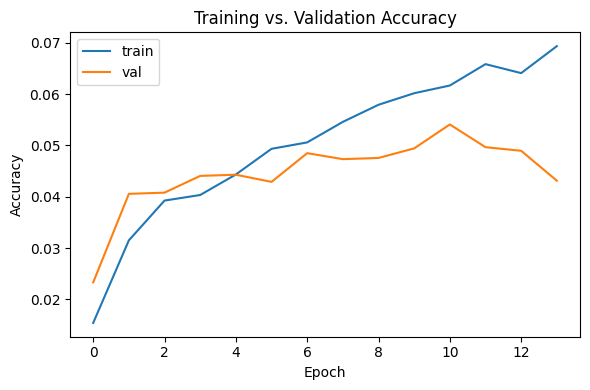

Final validation accuracy: 0.0541

>>> hls=[1024, 512] | act=relu | opt=Adam | lr=0.0001 | epochs=20
Training on 12000 images | validating on 4290 images
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - accuracy: 0.0105 - loss: 4.7787 - val_accuracy: 0.0231 - val_loss: 4.6615
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.0235 - loss: 4.6436 - val_accuracy: 0.0343 - val_loss: 4.5442
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.0342 - loss: 4.4977 - val_accuracy: 0.0410 - val_loss: 4.4352
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.0389 - loss: 4.4001 - val_accuracy: 0.0431 - val_loss: 4.3956
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.0460 - loss: 4.3392 - val_accuracy: 0.0473 - val_loss: 4.3631
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.0487 - loss: 4.3000 - val_accuracy: 0.0510 - val_loss: 4.3374
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - acc

Final validation accuracy: 0.0650

>>> hls=[1024, 512] | act=tanh | opt=Adam | lr=0.001 | epochs=20
Training on 12000 images | validating on 4290 images
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.0056 - loss: 4.9343 - val_accuracy: 0.0098 - val_loss: 4.9078
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.0073 - loss: 4.9585 - val_accuracy: 0.0098 - val_loss: 4.9093
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.0071 - loss: 4.9587 - val_accuracy: 0.0098 - val_loss: 4.9059
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.0078 - loss: 4.9578 - val_accuracy: 0.0058 - val_loss: 4.9090
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.0065 - loss: 4.9566 - val_accuracy: 0.0098 - val_loss: 4.9088
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.0072 - loss: 4.9579 - val_accuracy: 0.0098 - val_loss: 4.9075


Final validation accuracy: 0.0098

>>> hls=[1024, 512] | act=tanh | opt=Adam | lr=0.0001 | epochs=20
Training on 12000 images | validating on 4290 images
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - accuracy: 0.0136 - loss: 4.7852 - val_accuracy: 0.0245 - val_loss: 4.6583
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.0281 - loss: 4.6114 - val_accuracy: 0.0380 - val_loss: 4.5039
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.0381 - loss: 4.4537 - val_accuracy: 0.0438 - val_loss: 4.4131
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.0482 - loss: 4.3618 - val_accuracy: 0.0508 - val_loss: 4.3631
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.0470 - loss: 4.3125 - val_accuracy: 0.0517 - val_loss: 4.3271
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.0528 - loss: 4.2774 - val_accuracy: 0.0531 - val_loss: 4.2913
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy:

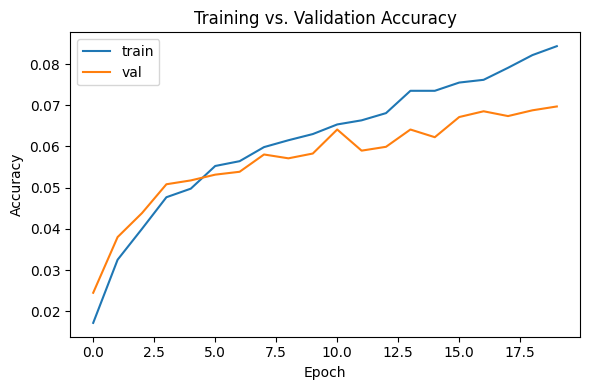

Final validation accuracy: 0.0697

>>> hls=[256] | act=relu | opt=Adam | lr=0.001 | epochs=20
Training on 12000 images | validating on 4290 images
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.0100 - loss: 4.7876 - val_accuracy: 0.0184 - val_loss: 4.6439
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.0231 - loss: 4.6277 - val_accuracy: 0.0270 - val_loss: 4.5466
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.0251 - loss: 4.5348 - val_accuracy: 0.0345 - val_loss: 4.4605
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.0306 - loss: 4.4546 - val_accuracy: 0.0378 - val_loss: 4.4204
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.0340 - loss: 4.4229 - val_accuracy: 0.0424 - val_loss: 4.3954
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.0367 - loss: 4.3941 - val_accuracy: 0.0424 - val_loss: 4.3803
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.0392 -

Final validation accuracy: 0.0408

>>> hls=[256] | act=relu | opt=Adam | lr=0.0001 | epochs=20
Training on 12000 images | validating on 4290 images
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.0100 - loss: 4.7811 - val_accuracy: 0.0198 - val_loss: 4.6990
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.0206 - loss: 4.6783 - val_accuracy: 0.0277 - val_loss: 4.6150
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.0245 - loss: 4.5869 - val_accuracy: 0.0352 - val_loss: 4.5413
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.0325 - loss: 4.5110 - val_accuracy: 0.0364 - val_loss: 4.4890
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.0388 - loss: 4.4524 - val_accuracy: 0.0422 - val_loss: 4.4544
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.0450 - loss: 4.4173 - val_accuracy: 0.0436 - val_loss: 4.4227
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.0466

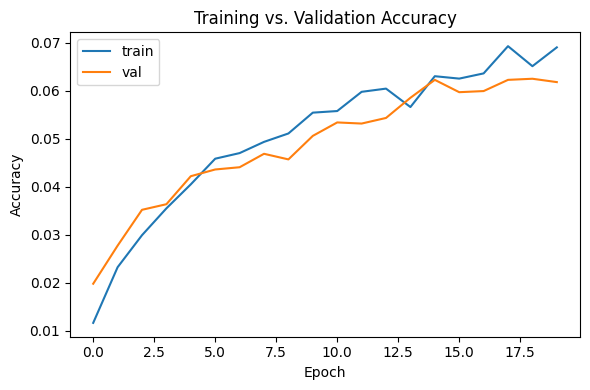

Final validation accuracy: 0.0618

>>> hls=[256] | act=tanh | opt=Adam | lr=0.001 | epochs=20
Training on 12000 images | validating on 4290 images
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.0063 - loss: 4.8679 - val_accuracy: 0.0084 - val_loss: 4.8320
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.0091 - loss: 4.8411 - val_accuracy: 0.0105 - val_loss: 4.7994
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.0111 - loss: 4.8013 - val_accuracy: 0.0126 - val_loss: 4.7708
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.0136 - loss: 4.7671 - val_accuracy: 0.0126 - val_loss: 4.7419
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.0150 - loss: 4.7374 - val_accuracy: 0.0128 - val_loss: 4.7226
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.0146 - loss: 4.7121 - val_accuracy: 0.0196 - val_loss: 4.6886
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.0189 

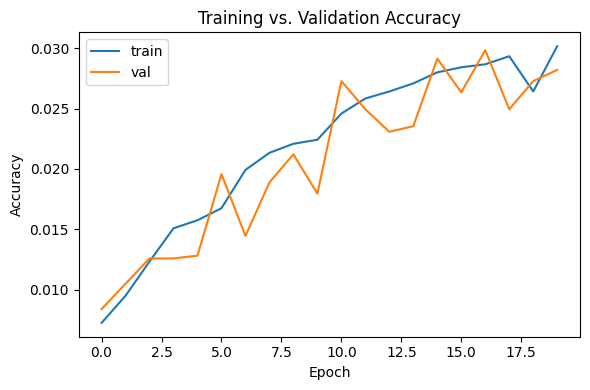

Final validation accuracy: 0.0282

>>> hls=[256] | act=tanh | opt=Adam | lr=0.0001 | epochs=20
Training on 12000 images | validating on 4290 images
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.0094 - loss: 4.7846 - val_accuracy: 0.0221 - val_loss: 4.7163
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.0240 - loss: 4.6887 - val_accuracy: 0.0294 - val_loss: 4.6381
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.0327 - loss: 4.6022 - val_accuracy: 0.0343 - val_loss: 4.5646
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.0384 - loss: 4.5284 - val_accuracy: 0.0396 - val_loss: 4.5080
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.0457 - loss: 4.4663 - val_accuracy: 0.0413 - val_loss: 4.4635
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.0472 - loss: 4.4228 - val_accuracy: 0.0422 - val_loss: 4.4319
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.0497

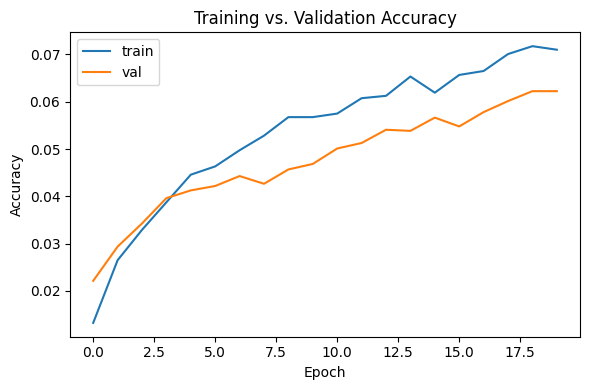

Final validation accuracy: 0.0622

================  Grid-Search Results  ================


hidden_layer_sizes activation optimizer  learning_rate  num_epochs  \
0    [1024, 512, 256]       relu      Adam         0.0010          20   
1    [1024, 512, 256]       relu      Adam         0.0001          20   
2    [1024, 512, 256]       tanh      Adam         0.0010          20   
3    [1024, 512, 256]       tanh      Adam         0.0001          20   
4         [1024, 512]       relu      Adam         0.0010          20   
5         [1024, 512]       relu      Adam         0.0001          20   
6         [1024, 512]       tanh      Adam         0.0010          20   
7         [1024, 512]       tanh      Adam         0.0001          20   
8               [256]       relu      Adam         0.0010          20   
9               [256]       relu      Adam         0.0001          20   
10              [256]       tanh      Adam         0.0010          20   
11              [256]       tanh      Adam         0.0001          20   

    train_acc   val_acc  overfit_gap  
0    0.062917  0.047786     0.015131  
1    0.089667  0.063869     0.025797  
2    0.008333  0.006527     0.001807  
3    0.078750  0.058042     0.020708  
4    0.069167  0.054079     0.015087  
5    0.098917  0.065035     0.033882  
6    0.008333  0.009790    -0.001457  
7    0.092333  0.069697     0.022636  
8    0.047167  0.040793     0.006374  
9    0.076167  0.061772     0.014395  
10   0.032167  0.028205     0.003962  
11   0.073250  0.062238     0.011012


================  BEST CONFIGURATION  =================
{'hidden_layer_sizes': [1024, 512], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.0001, 'num_epochs': 20, 'train_acc': 0.09233333170413971, 'val_acc': 0.06969697028398514, 'overfit_gap': 0.02263636142015457}


In [9]:
# ------------------------------------------------------------------
# Assumptions
# ------------------------------------------------------------------
# • X_train, X_val, X_test          ← full image arrays
# • y_train_encoded, y_val_encoded  ← integers from LabelEncoder
# • data_augmentation               ← (optional) tf.keras.Sequential pipeline
# • train_and_evaluate(...)         ← same helper we wrote earlier

# ------------------------------------------------------------------
# 1.  Search space
# ------------------------------------------------------------------
hidden_layer_sizes_list = [
    [1024, 512, 256],
    [1024, 512],
    [256],
]
activations     = ['relu', 'tanh']
optimizers      = ['Adam']
learning_rates  = [1e-3, 1e-4]
num_epochs_list = [20]

results   = []

# Shared EarlyStopping callback (re-used across trials)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ------------------------------------------------------------------
# 2.  Grid search
# ------------------------------------------------------------------
for hls, act, opt, lr, ne in itertools.product(
        hidden_layer_sizes_list,
        activations,
        optimizers,
        learning_rates,
        num_epochs_list):

    print(f"\n>>> hls={hls} | act={act} | opt={opt} | lr={lr} | epochs={ne}")

    try:
        model = train_and_evaluate(
            X_train, y_train_encoded,          # ⬅️ full dataset
            X_val,   y_val_encoded,            # ⬅️ full dataset
            hidden_layer_sizes=hls,
            activation=act,
            optimizer=opt,
            learning_rate=lr,
            num_epochs=ne,
            data_augmentation=data_augmentation,
            callbacks=[early_stop]             # shared ES
        )

        # Metrics
        train_loss, train_acc = model.evaluate(X_train, y_train_encoded, verbose=0)
        val_loss,   val_acc   = model.evaluate(X_val,   y_val_encoded,   verbose=0)

        results.append({
            'hidden_layer_sizes': hls,
            'activation': act,
            'optimizer': opt,
            'learning_rate': lr,
            'num_epochs': ne,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'overfit_gap': train_acc - val_acc,
            'model': model
        })

    except Exception as e:
        print(f"⚠️  skipped: {e}")
        continue

# ------------------------------------------------------------------
# 3.  Results table
# ------------------------------------------------------------------
results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'model'} for r in results
])

print("\n================  Grid-Search Results  ================")
display(results_df)

# ------------------------------------------------------------------
# 4.  Best model selection (low over-fit preferred)
# ------------------------------------------------------------------
filtered = results_df[results_df['overfit_gap'] < 0.05]
best_idx = filtered['val_acc'].idxmax() if not filtered.empty else results_df['val_acc'].idxmax()

best_row   = results_df.loc[best_idx]
best_model = results[best_idx]['model']

print("\n================  BEST CONFIGURATION  =================")
print(best_row.to_dict())

In [10]:
results_df.to_csv('results_df_early_stopping.csv', index=False)

In [11]:
results_df = pd.read_csv('results_df_early_stopping.csv')

In [12]:
results_df

hidden_layer_sizes activation optimizer  learning_rate  num_epochs  \
0    [1024, 512, 256]       relu      Adam         0.0010          20   
1    [1024, 512, 256]       relu      Adam         0.0001          20   
2    [1024, 512, 256]       tanh      Adam         0.0010          20   
3    [1024, 512, 256]       tanh      Adam         0.0001          20   
4         [1024, 512]       relu      Adam         0.0010          20   
5         [1024, 512]       relu      Adam         0.0001          20   
6         [1024, 512]       tanh      Adam         0.0010          20   
7         [1024, 512]       tanh      Adam         0.0001          20   
8               [256]       relu      Adam         0.0010          20   
9               [256]       relu      Adam         0.0001          20   
10              [256]       tanh      Adam         0.0010          20   
11              [256]       tanh      Adam         0.0001          20   

    train_acc   val_acc  overfit_gap  
0    0.062917  0.047786     0.015131  
1    0.089667  0.063869     0.025797  
2    0.008333  0.006527     0.001807  
3    0.078750  0.058042     0.020708  
4    0.069167  0.054079     0.015087  
5    0.098917  0.065035     0.033882  
6    0.008333  0.009790    -0.001457  
7    0.092333  0.069697     0.022636  
8    0.047167  0.040793     0.006374  
9    0.076167  0.061772     0.014395  
10   0.032167  0.028205     0.003962  
11   0.073250  0.062238     0.011012

In [ ]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

test_loss, test_acc = best_model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

y_test_pred = np.argmax(best_model.predict(X_test, batch_size=64, verbose=0), axis=1)

f1_macro    = f1_score(y_test_encoded, y_test_pred, average='macro')
f1_weighted = f1_score(y_test_encoded, y_test_pred, average='weighted')

print(f"Macro F1 Score:    {f1_macro:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test_encoded, y_test_pred, digits=3))

Test Accuracy: 0.0709
Macro F1 Score:    0.0482
Weighted F1 Score: 0.0510

--- Classification Report ---
              precision    recall  f1-score   support

           0      0.143     0.120     0.130        25
           1      0.156     0.071     0.098        70
           2      0.048     0.086     0.062        35
           3      0.116     0.098     0.106        51
           4      0.000     0.000     0.000        32
           5      0.067     0.038     0.049        26
           6      0.097     0.062     0.076        48
           7      0.167     0.019     0.033        54
           8      0.060     0.079     0.068        38
           9      0.081     0.064     0.071        47
          10      0.033     0.024     0.028        41
          11      0.056     0.017     0.026        59
          12      0.000     0.000     0.000        29
          13      0.125     0.068     0.088        44
          14      0.000     0.000     0.000        43
          15      0.000     0.

c:\Users\casti\OneDrive\Documents\207 - Machine Learning Actual\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\casti\OneDrive\Documents\207 - Machine Learning Actual\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\casti\OneDrive\Documents\207 - Machine Learning Actual\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

labels = np.arange(len(label_encoder.classes_))
cm = confusion_matrix(
    y_test_encoded,
    y_test_pred,
    labels=labels
)

most_confused = []
for i, true_label in enumerate(labels):
    row = cm[i].copy()
    row[i] = 0  # zero-out correct preds
    if row.sum() == 0:
        # Perfect class — no confusions
        most_confused.append({
            "True Class": label_encoder.inverse_transform([true_label])[0],
            "Top Wrong Class": "--",
            "Count": 0,
            "Support": cm[i].sum(),
            "Recall (%)": 100.0
        })
        continue

    pred_label = row.argmax()
    most_confused.append({
        "True Class": label_encoder.inverse_transform([true_label])[0],
        "Top Wrong Class": label_encoder.inverse_transform([pred_label])[0],
        "Count": row[pred_label],
        "Support": cm[i].sum(),
        "Recall (%)": 100 * cm[i, i] / cm[i].sum()
    })

confusion_df = pd.DataFrame(most_confused).sort_values("Count", ascending=False)

display(confusion_df.head(15))   # show 15 worst-offenders

True Class              Top Wrong Class  Count  Support  \
73            maltese_dog                      samoyed     16       76   
69               leonberg            brabancon_griffon     15       55   
94                samoyed  west_highland_white_terrier     14       59   
97     scottish_deerhound                  entlebucher     13       66   
52         great_pyrenees                       kuvasz     12       57   
78           newfoundland                  groenendael     11       47   
84               papillon             english_springer      9       48   
10     bedlington_terrier                      samoyed      9       41   
48        giant_schnauzer                  groenendael      8       29   
14             bloodhound                 irish_setter      8       43   
100                  shih             sealyham_terrier      7       57   
59        irish_wolfhound                   great_dane      7       59   
2     african_hunting_dog                     leonberg      7       35   
11   bernese_mountain_dog                  entlebucher      7       59   
117               whippet                     leonberg      7       43   

     Recall (%)  
73     9.210526  
69    16.363636  
94    23.728814  
97     4.545455  
52     0.000000  
78    23.404255  
84     6.250000  
10     2.439024  
48     0.000000  
14     0.000000  
100    1.754386  
59     0.000000  
2      8.571429  
11     1.694915  
117    0.000000

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(
    y_test_encoded,
    y_test_pred,
    target_names=label_encoder.classes_,
    output_dict=True
)

# Extract F1 scores (ignore 'accuracy', 'macro avg', etc.)
f1_scores = []
for breed, metrics in report.items():
    if breed not in ['accuracy', 'macro avg', 'weighted avg']:
        f1_scores.append({
            "Breed": breed,
            "F1 Score": metrics["f1-score"],
            "Precision": metrics["precision"],
            "Recall": metrics["recall"],
            "Support": metrics["support"]
        })

f1_df = pd.DataFrame(f1_scores)

top5    = f1_df.sort_values("F1 Score", ascending=False).head(5)
bottom5 = f1_df.sort_values("F1 Score", ascending=True).head(5)

print("🔝 Top 5 Breeds by F1 Score:")
display(top5)

print("\n🔻 Bottom 5 Breeds by F1 Score:")
display(bottom5)


🔝 Top 5 Breeds by F1 Score:


c:\Users\casti\OneDrive\Documents\207 - Machine Learning Actual\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\casti\OneDrive\Documents\207 - Machine Learning Actual\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\casti\OneDrive\Documents\207 - Machine Learning Actual\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

Breed  F1 Score  Precision    Recall  Support
98      sealyham_terrier  0.340659   0.236641  0.607843     51.0
42           entlebucher  0.171717   0.115646  0.333333     51.0
39      english_foxhound  0.170213   0.121212  0.285714     28.0
82  old_english_sheepdog  0.168421   0.133333  0.228571     35.0
94               samoyed  0.160000   0.120690  0.237288     59.0


🔻 Bottom 5 Breeds by F1 Score:


Breed  F1 Score  Precision  Recall  Support
4   american_staffordshire_terrier       0.0        0.0     0.0     32.0
12                           black       0.0        0.0     0.0     29.0
15                        bluetick       0.0        0.0     0.0     36.0
14                      bloodhound       0.0        0.0     0.0     43.0
20            bouvier_des_flandres       0.0        0.0     0.0     25.0

## Training without early stopping

In [1]:
# Train the model on the full dataset
model_full = train_and_evaluate(
    X_train, y_train_encoded,
    X_val, y_val_encoded,
    hidden_layer_sizes=[1024, 512],
    activation='relu',
    optimizer='Adam',
    learning_rate=1e-4,
    num_epochs=20,
    data_augmentation=data_augmentation
)

NameError: name 'train_and_evaluate' is not defined

In [ ]:
import json

def save_model_complete(model, label_encoder, config, filepath_prefix='data/model'):
    """
    Save model, weights, configuration, and label encoder
    """
    # Save the model
    model.save(f'{filepath_prefix}.keras')
    
    # Save configuration
    config['label_encoder_classes'] = label_encoder.classes_.tolist()
    with open(f'{filepath_prefix}_config.json', 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"Model saved to {filepath_prefix}.keras")
    print(f"Config saved to {filepath_prefix}_config.json")

def load_model_complete(filepath_prefix='data/model'):
    """
    Load model, configuration, and recreate label encoder
    """
    # Load model
    model = tf.keras.models.load_model(f'{filepath_prefix}.keras')
    
    # Load configuration
    with open(f'{filepath_prefix}_config.json', 'r') as f:
        config = json.load(f)
    
    # Recreate label encoder
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(config['label_encoder_classes'])
    
    return model, label_encoder, config

# Usage:
training_config = {
    'hidden_layer_sizes': [1024, 512],
    'activation': 'relu',
    'optimizer': 'Adam',
    'learning_rate': 1e-4,
    'num_epochs': 20,
    'n_classes': len(np.unique(y_train_encoded)),
    'input_shape': X_train.shape[1:],
    'data_augmentation_used': True
}

# Save everything
save_model_complete(model_full, label_encoder, training_config, 'best_full_model')

# Later, load everything
loaded_model, loaded_encoder, loaded_config = load_model_complete('best_full_model')

Model saved to best_full_model.keras
Config saved to best_full_model_config.json


In [ ]:
train_loss, train_acc = model_full.evaluate(X_train, y_train_encoded, verbose=0)
print(f"Train accuracy: {train_acc:.4f}")

Train accuracy: 0.1033


In [ ]:
import numpy as np

# Get model predictions on validation set
y_val_pred_probs = model_full.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val_encoded, y_val_pred)

# For each true class, count how many times it was misclassified (sum of row minus diagonal)
misclass_counts = cm.sum(axis=1) - np.diag(cm)

# Get indices of most misclassified breeds
most_misclassified_idx = np.argsort(misclass_counts)[::-1]

# Get breed names from label encoder
breed_names = label_encoder.classes_

print("Most misclassified breeds (by true label):")
for idx in most_misclassified_idx[:10]:  # Top 10
    print(f"{breed_names[idx]}: {misclass_counts[idx]} misclassified")

# Optionally, show which classes they are most often confused with
print("\nFor each, most confused with:")
for idx in most_misclassified_idx[:5]:
    # Exclude the diagonal (correct predictions)
    confused_with_idx = np.argsort(cm[idx, :] - np.eye(cm.shape[0])[idx]*cm[idx, :])[-2::-1]
    # Only show the most confused class (excluding itself)
    most_confused_with = confused_with_idx[0]
    print(f"{breed_names[idx]} is most often confused with {breed_names[most_confused_with]} ({cm[idx, most_confused_with]} times)")


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Most misclassified breeds (by true label):
maltese_dog: 75 misclassified
afghan_hound: 64 misclassified
pomeranian: 60 misclassified
irish_wolfhound: 58 misclassified
great_pyrenees: 56 misclassified
bernese_mountain_dog: 55 misclassified
basenji: 55 misclassified
shih: 53 misclassified
tibetan_terrier: 52 misclassified
saluki: 50 misclassified

For each, most confused with:
maltese_dog is most often confused with kuvasz (9 times)
afghan_hound is most often confused with groenendael (5 times)
pomeranian is most often confused with irish_setter (6 times)
irish_wolfhound is most often confused with bedlington_terrier (4 times)
great_pyrenees is most often confused with samoyed (7 times)


Poor (but better than random which would be ~0.8%). The model is now underfitting, and we still lack spatial inductive bias. (Doesn't recognize ear shape etc.)

## Hyperparameter Tuning

Starting quick grid search with 4 combinations
Estimated time: 20-40 minutes

Testing: hidden_layer_sizes=[1024, 512], learning_rate=0.001, num_epochs=10

Training on 12000 images, validating on 4290 images ...
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.0126 - loss: 4.8537 - val_accuracy: 0.0191 - val_loss: 4.6391
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.0160 - loss: 4.6383 - val_accuracy: 0.0161 - val_loss: 4.6374
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.0166 - loss: 4.6045 - val_accuracy: 0.0182 - val_loss: 4.5858
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.0231 - loss: 4.5459 - val_accuracy: 0.0291 - val_loss: 4.5201
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.0278 - loss: 4.4824 - val_accuracy: 0.0266 - val_loss: 4.4891
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.0311 - loss: 4.4327 - val_accuracy: 0.0350 - val_loss: 4.4599
Epoch 

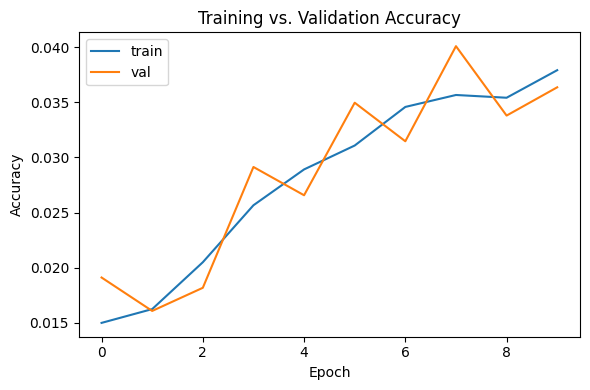

Final validation accuracy: 0.0364
✅ Train Acc: 0.0422, Val Acc: 0.0364, Overfit Gap: 0.0059

Testing: hidden_layer_sizes=[1024, 512], learning_rate=0.0001, num_epochs=10
Training on 12000 images, validating on 4290 images ...
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.0102 - loss: 4.7851 - val_accuracy: 0.0179 - val_loss: 4.6618
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.0179 - loss: 4.6270 - val_accuracy: 0.0228 - val_loss: 4.6100
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.0247 - loss: 4.5633 - val_accuracy: 0.0259 - val_loss: 4.5714
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.0300 - loss: 4.5069 - val_accuracy: 0.0270 - val_loss: 4.5219
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.0370 - loss: 4.4552 - val_accuracy: 0.0289 - val_loss: 4.4820
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.0359 - loss: 4.4079 - val_accuracy: 0.0294 - val_loss:

Final validation accuracy: 0.0385
✅ Train Acc: 0.0490, Val Acc: 0.0385, Overfit Gap: 0.0105

Testing: hidden_layer_sizes=[512, 256], learning_rate=0.001, num_epochs=10
Training on 12000 images, validating on 4290 images ...
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.0117 - loss: 4.7779 - val_accuracy: 0.0166 - val_loss: 4.6189
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.0184 - loss: 4.6145 - val_accuracy: 0.0219 - val_loss: 4.5673
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.0232 - loss: 4.5368 - val_accuracy: 0.0277 - val_loss: 4.5105
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.0301 - loss: 4.4642 - val_accuracy: 0.0305 - val_loss: 4.4467
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.0310 - loss: 4.4256 - val_accuracy: 0.0336 - val_loss: 4.4504
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.0342 - loss: 4.3952 - val_accuracy: 0.0275 - val_loss: 4.4633
E

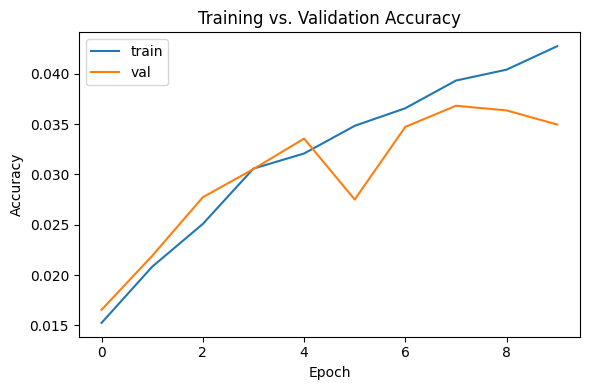

Final validation accuracy: 0.0350
✅ Train Acc: 0.0446, Val Acc: 0.0350, Overfit Gap: 0.0096

Testing: hidden_layer_sizes=[512, 256], learning_rate=0.0001, num_epochs=10
Training on 12000 images, validating on 4290 images ...
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.0120 - loss: 4.7796 - val_accuracy: 0.0172 - val_loss: 4.6654
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.0187 - loss: 4.6288 - val_accuracy: 0.0217 - val_loss: 4.6257
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.0224 - loss: 4.5850 - val_accuracy: 0.0235 - val_loss: 4.5947
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.0276 - loss: 4.5375 - val_accuracy: 0.0282 - val_loss: 4.5514
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.0323 - loss: 4.4871 - val_accuracy: 0.0324 - val_loss: 4.5054
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.0320 - loss: 4.4401 - val_accuracy: 0.0326 - val_loss: 4.4

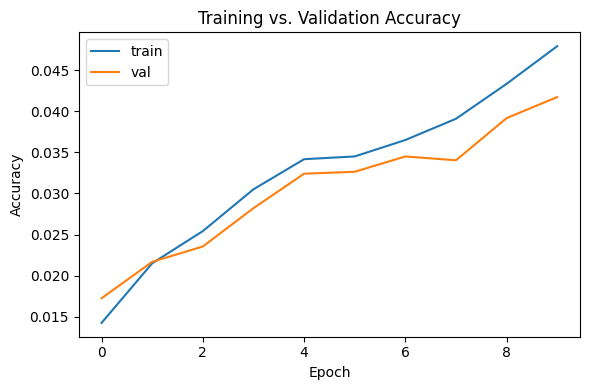

Final validation accuracy: 0.0417
✅ Train Acc: 0.0496, Val Acc: 0.0417, Overfit Gap: 0.0079

Quick Grid Search Results:


hidden_layer_sizes  learning_rate  num_epochs  train_acc   val_acc  \
0        [1024, 512]         0.0010          10   0.042250  0.036364   
1        [1024, 512]         0.0001          10   0.049000  0.038462   
2         [512, 256]         0.0010          10   0.044583  0.034965   
3         [512, 256]         0.0001          10   0.049583  0.041725   

   train_loss  val_loss  overfit_gap  
0    4.362464  4.457459     0.005886  
1    4.290070  4.400991     0.010538  
2    4.338414  4.462357     0.009618  
3    4.312739  4.400721     0.007858


�� Best Configuration:
{'hidden_layer_sizes': [512, 256], 'learning_rate': 0.0001, 'num_epochs': 10, 'train_acc': 0.04958333447575569, 'val_acc': 0.04172494262456894, 'train_loss': 4.312739372253418, 'val_loss': 4.400721073150635, 'overfit_gap': 0.007858391851186752}
Best model saved as 'best_full_model_quick.keras'


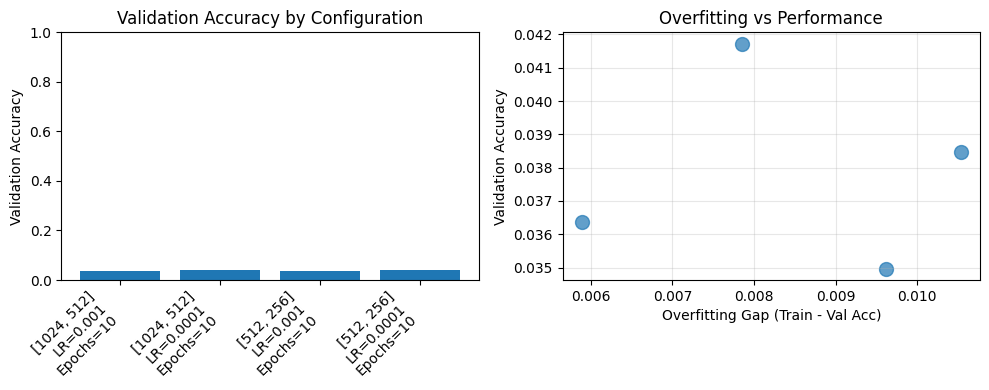


�� Summary:
Best validation accuracy: 0.0417
Best overfitting gap: 0.0079
Configuration: [512, 256], LR=0.0001, Epochs=10


In [ ]:
hidden_layer_sizes_list = [
    [1024, 512],
    [512, 256]
]

learning_rates = [1e-3, 1e-4]
batch_sizes = [64]
num_epochs_list = [10]

results = []

total_combinations = len(hidden_layer_sizes_list) * len(learning_rates) * len(batch_sizes) * len(num_epochs_list)
print(f"Starting quick grid search with {total_combinations} combinations")
print("Estimated time: 20-40 minutes")

for hls, lr, bs, ne in itertools.product(
        hidden_layer_sizes_list, learning_rates, batch_sizes, num_epochs_list):

    print(f"\nTesting: hidden_layer_sizes={hls}, learning_rate={lr}, num_epochs={ne}")
    
    try:
        model = train_and_evaluate(
            X_train, y_train_encoded,
            X_val, y_val_encoded,
            hidden_layer_sizes=hls,
            activation='relu',
            optimizer='Adam',
            learning_rate=lr,
            num_epochs=ne,
            batch_size=bs,
            data_augmentation=data_augmentation
        )
        
        train_loss, train_acc = model.evaluate(X_train, y_train_encoded, verbose=0, batch_size=bs)
        val_loss, val_acc = model.evaluate(X_val, y_val_encoded, verbose=0, batch_size=bs)
        overfit_gap = train_acc - val_acc

        results.append({
            'hidden_layer_sizes': hls,
            'learning_rate': lr,
            'num_epochs': ne,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'overfit_gap': overfit_gap,
            'model': model
        })
        
        print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Overfit Gap: {overfit_gap:.4f}")
        
    except Exception as e:
        print(f"Error with configuration: {e}")
        continue

results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'model'} for r in results
])

print("\nQuick Grid Search Results:")
display(results_df)

best_idx = results_df['val_acc'].idxmax()
best_row = results_df.loc[best_idx]
best_model = results[best_idx]['model']

print("\nBest Configuration:")
print(best_row.to_dict())

best_model.save('best_full_model_quick.keras')
print("Best model saved as 'best_full_model_quick.keras'")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
configs = [f"{row['hidden_layer_sizes']}\nLR={row['learning_rate']}\nEpochs={row['num_epochs']}" 
           for _, row in results_df.iterrows()]
plt.bar(range(len(configs)), results_df['val_acc'])
plt.xticks(range(len(configs)), configs, rotation=45, ha='right')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy by Configuration')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.scatter(results_df['overfit_gap'], results_df['val_acc'], s=100, alpha=0.7)
plt.xlabel('Overfitting Gap (Train - Val Acc)')
plt.ylabel('Validation Accuracy')
plt.title('Overfitting vs Performance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"Best validation accuracy: {best_row['val_acc']:.4f}")
print(f"Best overfitting gap: {best_row['overfit_gap']:.4f}")
print(f"Configuration: {best_row['hidden_layer_sizes']}, LR={best_row['learning_rate']}, Epochs={best_row['num_epochs']}")

In [12]:
import keras_tuner as kt

def tuner_model_builder(hp):
    n_classes = len(np.unique(y_train_encoded))
    # Tune hidden layer sizes
    num_layers = hp.Int('num_layers', 1, 2)  # 1 or 2 hidden layers
    hidden_layer_sizes = []
    for i in range(num_layers):
        units = hp.Choice(f'units_{i}', [256, 512, 1024])
        hidden_layer_sizes.append(units)
    # Tune activation
    activation = hp.Choice('activation', ['relu', 'tanh'])
    # Tune optimizer
    optimizer = hp.Choice('optimizer', ['Adam', 'SGD'])
    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])
    
    model = build_model(
        n_classes=n_classes,
        input_shape=X_train.shape[1:],
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        optimizer=optimizer,
        learning_rate=learning_rate,
        metric='accuracy',
        data_augmentation=data_augmentation  # if you want augmentation
    )
    return model

In [13]:
tuner = kt.RandomSearch(
    tuner_model_builder,
    objective='val_accuracy',
    max_trials=10,  # You can increase for a more thorough search
    executions_per_trial=1,
    directory='kt_dir',
    project_name='my_model_tuning'
)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

tuner.search(
    X_train, y_train_encoded,
    epochs=20,
    validation_data=(X_val, y_val_encoded),
    callbacks=[early_stopping],
    verbose=1
)

Trial 3 Complete [00h 01m 50s]
val_accuracy: 0.036596737802028656

Best val_accuracy So Far: 0.036596737802028656
Total elapsed time: 00h 05m 41s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_layers
512               |256               |units_0
relu              |relu              |activation
Adam              |Adam              |optimizer
0.0001            |0.001             |learning_rate
512               |256               |units_1

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.0106 - loss: 4.7781 - val_accuracy: 0.0159 - val_loss: 4.6383
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.0182 - loss: 4.6196 - val_accuracy: 0.0186 - val_loss: 4.6067
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.0230 - loss: 4.5689 - val_accuracy: 0.0226 - val_loss: 4.5537
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.0282 - loss: 4.5011 - val

KeyboardInterrupt: 

In [9]:
import json
# Later, load everything back
def load_best_model_complete(filepath_prefix='data/best_tuned'):
    """Load the best model and configuration"""
    
    # Load model
    model = tf.keras.models.load_model(f'{filepath_prefix}_model.keras')
    
    # Load hyperparameters
    with open(f'{filepath_prefix}_hyperparameters.json', 'r') as f:
        hyperparameters = json.load(f)
    
    # Load results
    results = pd.read_csv(f'{filepath_prefix}_results.csv')
    
    return model, hyperparameters, results

# Usage
loaded_model, loaded_params, loaded_results = load_best_model_complete()

c:\Users\casti\OneDrive\Documents\207 - Machine Learning Actual\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# import pandas as pd

# # Get all trials
# trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))

# # Build a list of dicts for each trial
# results = []
# for trial in trials:
#     trial_dict = trial.hyperparameters.values.copy()
#     trial_dict['val_accuracy'] = trial.metrics.get_last_value('val_accuracy')
#     trial_dict['val_loss'] = trial.metrics.get_last_value('val_loss')
#     results.append(trial_dict)

# # Create DataFrame
# results_df = pd.DataFrame(results)

# # Sort by best validation accuracy
# results_df = results_df.sort_values('val_accuracy', ascending=False).reset_index(drop=True)

# print(results_df)

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
train_loss, train_acc = best_model.evaluate(X_train, y_train_encoded, verbose=0)
val_loss, val_acc = best_model.evaluate(X_val, y_val_encoded, verbose=0)
print(f"Best model train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}")

Training on 12000 images, validating on 4290 images ...
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.0085 - loss: 4.7820 - val_accuracy: 0.0217 - val_loss: 4.6949
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.0205 - loss: 4.6662 - val_accuracy: 0.0315 - val_loss: 4.5841
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.0336 - loss: 4.5561 - val_accuracy: 0.0359 - val_loss: 4.4908
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.0382 - loss: 4.4545 - val_accuracy: 0.0441 - val_loss: 4.4261
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.0418 - loss: 4.3880 - val_accuracy: 0.0464 - val_loss: 4.3860
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.0468 - loss: 4.3412 - val_accuracy: 0.0503 - val_loss: 4.3577
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.0481 - loss: 4.3064 - val_accuracy: 0.0510 - val_loss: 4.3366
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━

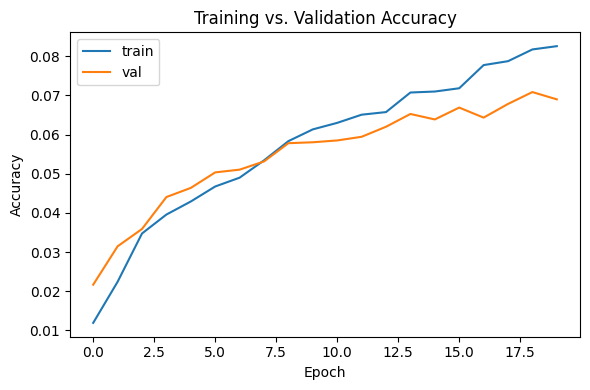

Final validation accuracy: 0.0690


In [10]:
# Your optimal parameters from the tuning
optimal_hidden_layers = [768, 768]  # From your results
optimal_learning_rate = 5.21e-05    # From your results
optimal_optimizer = 'Adam'          # Capitalize it!

# Train the model with optimal parameters
model_optimal = train_and_evaluate(
    X_train, y_train_encoded,
    X_val, y_val_encoded,
    hidden_layer_sizes=optimal_hidden_layers,  # [768, 768]
    activation='relu',
    optimizer=optimal_optimizer,               # 'Adam' (capitalized)
    learning_rate=optimal_learning_rate,       # 5.21e-05
    num_epochs=20,
    data_augmentation=data_augmentation
)